In [1]:
%run setup.py

In [2]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx =  (stars['ifmodelling']==1) \
    & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) \
    & np.isfinite(stars['[M/H]'])

stars = stars.loc[idx,:].reset_index(drop=True)

modes = pd.read_excel(rootpath+'surface/sample/modes.xlsx')

In [10]:
suf = '_micp'
original_cols = ['Dnu_freq_o', 'Dnu_freq', 'star_mass', 'radius', 'surf_corr_at_numax']
to_append_cols = [s+suf for s in ['Dnu_freq_o', 'Dnu_freq', 'mass', 'radius', 'surf_corr']]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_eddin_spec_gaia_nu_sc/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)
    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)


suf = '_mic'
original_cols = ['Dnu_freq', 'Dnu_freq_sc', 'star_mass', 'radius', 'surf_corr_at_numax']
to_append_cols = [s+suf for s in ['Dnu_freq_o', 'Dnu_freq', 'mass', 'radius', 'surf_corr']]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_eddin_spec_gaia_nu/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)
    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)


for suffix in ['_micp', '_mic']: #, '_combined_linear']: #
    gval = 'g'+suffix
    dval = 'density'+suffix
    mval = 'mass'+suffix
    rval = 'radius'+suffix
    e_gval = 'e_g'+suffix
    e_dval = 'e_density'+suffix
    e_mval = 'e_mass'+suffix
    e_rval = 'e_radius'+suffix
    stars[gval] = stars[mval]/stars[rval]**2.
    stars[e_gval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (2*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[gval]
    stars[dval] = stars[mval]/stars[rval]**3.
    stars[e_dval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (3*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[dval]

  0%|          | 0/1276 [00:00<?, ?it/s]

  0%|          | 0/1276 [00:00<?, ?it/s]

# Get Sharma+16 correction

In [104]:
from fdnu.asfgrid import Seism

idx = np.isfinite(stars['mass_micp'])

Nstar = np.sum(idx)
evstate= np.ones(Nstar)
logz=stars.loc[idx,'[M/H]'].to_numpy() #[-1.97,-1.98]
Teff=stars.loc[idx,'Teff'].to_numpy() #[4659.8,4903.2]
Dnu=stars.loc[idx,'Dnu'].to_numpy() #[8.81,13.1]
numax=stars.loc[idx,'numax'].to_numpy() #[92.36,157.3]
sobj=Seism(datadir='fdnu/')
# mass,radius=s.get_mass_radius(evstate,logz,Teff,Dnu,numax)
# logg=s.mr2logg(mass,radius)
logg=np.log10(stars.loc[idx,'g_micp'].to_numpy()/274)
mass=stars.loc[idx,'mass_micp'].to_numpy()
_,_,fdnu=sobj.get_dnu_numax(evstate,logz,Teff,mass,mass,logg,isfeh=True)

stars.loc[idx,'fdnu'] = fdnu

[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
outside interp range 21  out of  1226


# Change in Dnu due to surface effect

In [105]:
idx = (~np.isin(stars['names'], ['ngc6791', 'ngc6819', 'binary'])) & (stars['ruwe']<1.2) #& (stars['Nmodes0']>=5) #ngc6
sample = stars.loc[idx,:].reset_index(drop=True)

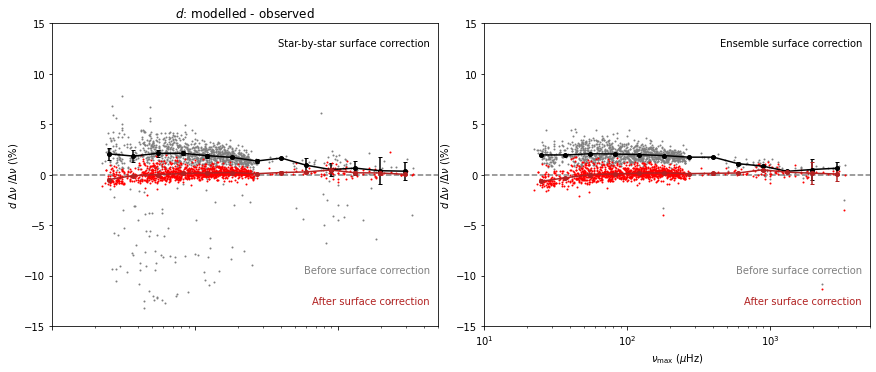

In [106]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)


fig, axes = plt.subplots(figsize=[12,5], nrows=1, ncols=2, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

# idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
# sample = stars.loc[idx,:]
idx = np.isfinite(stars['Dnu_freq_mic']) & ((stars['Dnu_freq_micp']/stars['Dnu']-1)<0.05) & (stars['Dnu']>3.0)

sample = stars.loc[idx,:]

styles1 = {'marker':'.', 'c':'gray', 's':4,}
estyles1 = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}


styles2 = {'marker':'.', 'c':'r', 's':4, 'zorder':10}
estyles2 = {'linestyle':'-', 'color':'firebrick', 'ecolor':'firebrick', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}


var = ['mic', 'micp']
# ['density', 'g', 'Dnu_scaling', 'Dnu_freq', 'Teff', 'amlt', 'Yinit', 'luminosity', 'numax']
lvar = ['Dnu', 'Dnu', 't']

for iax, ax in enumerate(axes[0:2]):
    
    var1 = 'Dnu_freq_o_'+var[iax]
    evar1 = 'e_Dnu_freq_o_'+var[iax]
    
    var2 = 'Dnu_freq_'+var[iax]
    evar2 = 'e_Dnu_freq_'+var[iax]
    
    var0 = 'Dnu'
    evar0 = 'e_Dnu'

    x = sample.loc[:,'numax']
    y1 = (sample.loc[:,var1]/sample.loc[:,var0]-1)*100
    y2 = (sample.loc[:,var2]/sample.loc[:,var0]-1)*100
    
    ex = sample.loc[:,'e_numax']
    ey1 = y1*((sample.loc[:,evar1]/sample.loc[:,var1])**2.0 + (sample.loc[:,evar0]/sample.loc[:,var0])**2.0)**0.5
    ey2 = y2*((sample.loc[:,evar2]/sample.loc[:,var2])**2.0 + (sample.loc[:,evar0]/sample.loc[:,var0])**2.0)**0.5
    
    idx = np.isfinite(x) & np.isfinite(y1) & np.isfinite(ey1) & np.isfinite(ex) & np.isfinite(y2) & np.isfinite(ey2)
    x,ex,y1,ey1,y2,ey2 = x[idx],ex[idx],y1[idx],ey1[idx],y2[idx],ey2[idx]
    
    xcs, medians, stds = se.get_binned_median(x, y1, np.logspace(np.log(20), np.log(3500), 14, base=np.e))
    ax.scatter(x, y1, rasterized=True,  **styles1)
#     ax.errorbar(x, y1, xerr=ex, yerr=ey1, **errorstyles1)
    ax.errorbar(xcs, medians, yerr=stds, **estyles1)
    
    xcs, medians, stds = se.get_binned_median(x, y2, np.logspace(np.log(20), np.log(3500), 14, base=np.e))
    ax.scatter(x, y2, rasterized=True,  **styles2)
#     ax.errorbar(x, y2, xerr=ex, yerr=ey2, **errorstyles2)
    ax.errorbar(xcs, medians, yerr=stds, **estyles2)
    
    ax.set_xlim(10, 5000)
    

    ax.set_xscale('log')
    ax.axhline(0., linestyle='--', color='gray')
    ax.set_ylabel('$d \\ \\Delta\\nu \\ / \\Delta\\nu$ (\\%)')


axes[0].set_title('$d$: modelled - observed')
axes[0].text(0.98, 0.95, 'Star-by-star surface correction', transform=axes[0].transAxes, ha='right', va='top', color='k')
axes[0].text(0.98, 0.20, 'Before surface correction', transform=axes[0].transAxes, ha='right', va='top', color='gray')
axes[0].text(0.98, 0.10, 'After surface correction', transform=axes[0].transAxes, ha='right', va='top', color='firebrick')

axes[1].text(0.98, 0.95, 'Ensemble surface correction', transform=axes[1].transAxes, ha='right', va='top', color='k')
axes[1].text(0.98, 0.20, 'Before surface correction', transform=axes[1].transAxes, ha='right', va='top', color='gray')
axes[1].text(0.98, 0.10, 'After surface correction', transform=axes[1].transAxes, ha='right', va='top', color='firebrick')


axes[-1].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
axes[0].set_xticklabels([])
axes[0].set_ylim(-15,15)
axes[1].set_ylim(-15,15)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)



# what is the best way of calculating model Dnu?
Here we try to find it by minimizing the differences of model Dnu and observed Dnu..
## optimizing Gaussian weighting

In [3]:
stars

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,_RA,_DE,...,ClcorR,e_ClcorR,Phase,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,ebv
0,0,1,NaN,1,0.0,NaN,esg,mu Her,266.61469,27.720621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,2991448,-1.0,1,0.0,NaN,esg,NaN,291.82490,38.113190,...,NaN,NaN,NaN,284.446259,275.085693,294.698334,277.899567,269.653534,288.931915,0.000000
2,3,4346201,-1.0,1,0.0,NaN,esg,NaN,285.28595,39.498050,...,NaN,NaN,NaN,243.909912,240.919601,247.180618,243.758667,240.746506,246.525421,0.000000
3,5,5607242,1.0,1,0.0,NaN,esg,NaN,287.64633,40.843060,...,NaN,NaN,NaN,333.288605,330.581085,335.470886,334.051239,331.574921,336.558716,0.009525
4,6,5689820,1.0,1,0.0,NaN,esg,NaN,286.22723,40.927730,...,NaN,NaN,NaN,337.830200,336.491333,339.050110,337.934021,336.425781,339.318787,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,1345,8430105,NaN,1,NaN,NaN,rgb,binary,291.55862,44.488190,...,NaN,NaN,NaN,725.739441,720.955627,731.051331,728.149170,721.238159,734.125183,0.060000
1272,1346,9153621,NaN,1,NaN,NaN,rgb,binary,291.41193,45.535190,...,NaN,NaN,NaN,2758.102050,2664.918950,2839.514650,2773.542480,2678.918700,2859.215330,0.050000
1273,1348,9540226,NaN,1,NaN,NaN,rgb,binary,297.03400,46.198470,...,14.43,0.88,0.0,1772.660160,1737.486330,1813.271120,1762.313230,1736.620240,1788.380490,0.130000
1274,1349,9970396,NaN,1,NaN,NaN,rgb,binary,298.70980,46.833030,...,NaN,NaN,NaN,977.215210,956.965759,992.817871,979.437073,963.291260,993.985168,0.176391


In [4]:
# dwarfs 
dwarfs = pd.read_csv('../../database/catalog/serenelli+17.csv')
dwarfs['numax_syd'] = dwarfs['numax']
dwarfs['e_numax_syd'] = dwarfs['e_numax']
dwarfs['Dnu_syd'] = dwarfs['Dnu']
dwarfs['e_Dnu_syd'] = dwarfs['e_Dnu']
dwarfs = dwarfs[['KIC','numax_syd','e_numax_syd','Dnu_syd','e_Dnu_syd']]

giants = pd.read_csv('../../database/catalog/yu+2018.csv')
giants['numax_syd'] = giants['numax']
giants['e_numax_syd'] = giants['e_numax']
giants['Dnu_syd'] = giants['Delnu']
giants['e_Dnu_syd'] = giants['e_Delnu']
giants = giants[['KIC','numax_syd','e_numax_syd','Dnu_syd','e_Dnu_syd']]

syd = pd.concat([dwarfs,giants],ignore_index=True)

In [5]:
stars = stars.merge(syd, on='KIC', how='left')

In [6]:
stars

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,_RA,_DE,...,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,ebv,numax_syd,e_numax_syd,Dnu_syd,e_Dnu_syd
0,0,1,NaN,1,0.0,NaN,esg,mu Her,266.61469,27.720621,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
1,1,2991448,-1.0,1,0.0,NaN,esg,NaN,291.82490,38.113190,...,275.085693,294.698334,277.899567,269.653534,288.931915,0.000000,1111.248,18.148,61.732,0.899
2,3,4346201,-1.0,1,0.0,NaN,esg,NaN,285.28595,39.498050,...,240.919601,247.180618,243.758667,240.746506,246.525421,0.000000,956.143,42.803,55.319,0.434
3,5,5607242,1.0,1,0.0,NaN,esg,NaN,287.64633,40.843060,...,330.581085,335.470886,334.051239,331.574921,336.558716,0.009525,676.118,7.613,40.628,0.073
4,6,5689820,1.0,1,0.0,NaN,esg,NaN,286.22723,40.927730,...,336.491333,339.050110,337.934021,336.425781,339.318787,0.010000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,1345,8430105,NaN,1,NaN,NaN,rgb,binary,291.55862,44.488190,...,720.955627,731.051331,728.149170,721.238159,734.125183,0.060000,NaN,NaN,NaN,NaN
1274,1346,9153621,NaN,1,NaN,NaN,rgb,binary,291.41193,45.535190,...,2664.918950,2839.514650,2773.542480,2678.918700,2859.215330,0.050000,NaN,NaN,NaN,NaN
1275,1348,9540226,NaN,1,NaN,NaN,rgb,binary,297.03400,46.198470,...,1737.486330,1813.271120,1762.313230,1736.620240,1788.380490,0.130000,27.390,1.540,3.192,0.026
1276,1349,9970396,NaN,1,NaN,NaN,rgb,binary,298.70980,46.833030,...,956.965759,992.817871,979.437073,963.291260,993.985168,0.176391,NaN,NaN,NaN,NaN


In [111]:
data = []
idx = (stars['ifmodelling']==1)  & np.isfinite(stars['Dnu_syd']) \
        & np.isfinite(stars['e_Dnu_syd']) \
        & np.isfinite(stars['numax_syd']) \
        & np.isfinite(stars['e_numax_syd'])


def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return None
    f = h5py.File(filepath, 'r')
    chi2 = f['chi2'][:]
    prob = np.exp(-chi2/2)
    idx = prob>1e-7
    
    if np.sum(idx) > 10:
        stardata = {'KIC': star['KIC'],
                    'prob': prob[idx], 
                    'Nmodels': f['mod_freq'][:][idx,:].shape[0],
                    'Nmodes': f['mod_freq'][:][idx,:].shape[1],
                    'mod_freq': f['mod_freq'][:][idx,:], 
                    'numax': f['numax_scaling'][:][idx],
                    'mass': f['star_mass'][:][idx],
                    'radius': f['radius'][:][idx],
                    'Teff': f['Teff'][:][idx],
                    'Dnu_syd': star['Dnu_syd'],
                    'numax_syd': star['numax_syd'], 
                    'e_Dnu_syd': star['e_Dnu_syd'],
                    'e_numax_syd': star['e_numax_syd'], }
        return stardata
    else:
        return None

r = process_map(multi, stars.loc[idx,:].iterrows(), total=np.sum(idx), max_workers=16)
data = [s for s in r if s is not None]

  0%|          | 0/1248 [00:00<?, ?it/s]

In [112]:
# np.save('data/stellar_models_for_Dnu_optimization', data)

In [7]:
data = list(np.load('data/stellar_models_for_Dnu_optimization.npy',allow_pickle=True))

In [43]:
import jax.numpy as jnp
import jax

Nstars = len(data)
numaxes = [jnp.asarray(data[istar]['numax']) for istar in range(Nstars)]
masses = [jnp.asarray(data[istar]['mass']) for istar in range(Nstars)]
radii = [jnp.asarray(data[istar]['radius']) for istar in range(Nstars)]
Teffs = [jnp.asarray(data[istar]['Teff']) for istar in range(Nstars)]
Nmodels = [data[istar]['Nmodels'] for istar in range(Nstars)]
Nmodes = [data[istar]['Nmodes'] for istar in range(Nstars)]

@jax.jit
def model(thetas):
    a, b, c, d = thetas
    chi2 = jnp.zeros(Nstars)
    for istar in range(Nstars):
        numax = numaxes[istar]
        sig = a * (numax/3090)**b
        sig = sig.reshape(-1,1) # (Nmodels, 1)
        numax = numax.reshape(-1,1) # (Nmodels, 1)
        weights = 1./(sig*(2*jnp.pi)) * jnp.exp(-(data[istar]['mod_freq']-numax)**2.0/sig**2.0) # (Nmodels, Nmodes)
        
        Ns = jnp.arange(Nmodes[istar]).reshape(1,-1)
        mod_freqs = data[istar]['mod_freq'][:,:] # (Nmodel, Nmodes)
        num = (-jnp.sum(weights*Ns, axis=1)*jnp.sum(weights*mod_freqs, axis=1) + \
         jnp.sum(weights, axis=1)*jnp.sum(weights*Ns*mod_freqs, axis=1) )
        den = (jnp.sum(weights, axis=1)*jnp.sum(weights*Ns**2., axis=1) - jnp.sum(weights*Ns, axis=1)**2. )

        Dnu_mod = jnp.average(num/den, weights=data[istar]['prob']) 
        chi2 = chi2.at[istar].set(Dnu_mod-data[istar]['Dnu_syd'])**2.0/(data[istar]['e_Dnu_syd']**2.0)
    return jnp.sum(chi2)

In [45]:
# model(jnp.asarray([381.1901, 0.3506, -1.9686, 0.5103]))

In [ ]:
# print(jit_model_linear(paramsInit))

# print(jax.grad(jit_model_linear)(paramsInit))

In [ ]:
# %timeit jit_model_linear(paramsInit)

In [ ]:
# import optax

# def fit(params, optimizer):
#     opt_state = optimizer.init(params)

#     @jax.jit
#     def step(params, opt_state):
#         loss_value, grads = jax.value_and_grad(model_linear)(params)
#         updates, opt_state = optimizer.update(grads, opt_state, params)
#         params = optax.apply_updates(params, updates)
#         return params, opt_state, loss_value

#     for i  in range(10000):
#         params, opt_state, loss_value = step(params, opt_state)
#         if i % 200 == 0:
#             print(f'step {i}, loss: {loss_value}')

#     return params

# # Finally, we can fit our parametrized function using the Adam optimizer
# # provided by optax.
# optimizer = optax.adam(learning_rate=2e-2)
# params = fit(paramsInit, optimizer)

In [39]:
# %run Dnu_optimization.py

Nsample: 20000
np.array([279.1666, 0.2962, -1.9701, 0.3681])


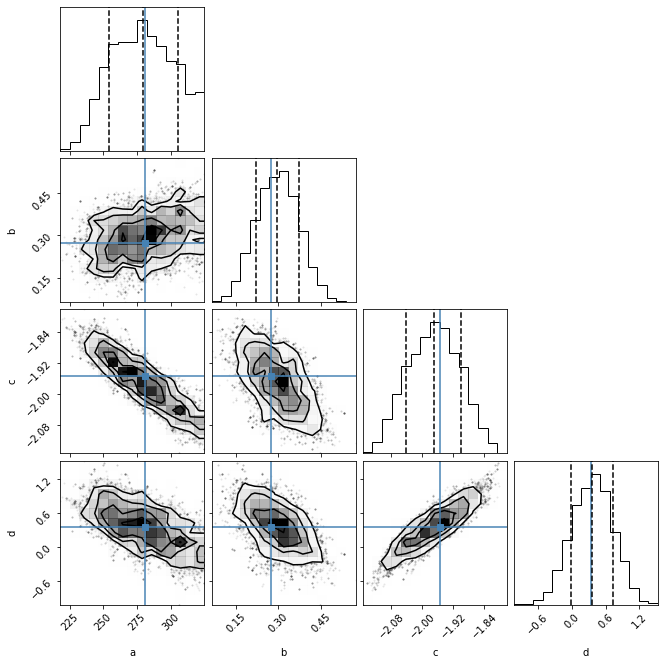

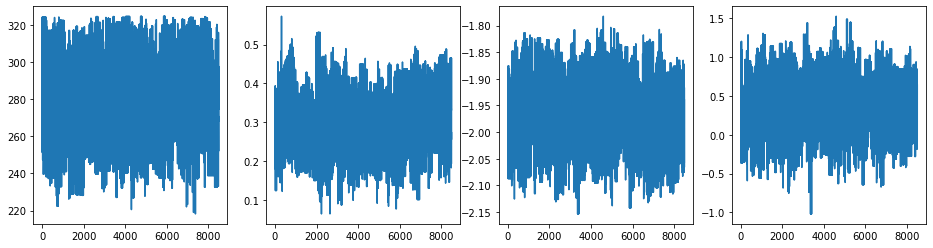

In [80]:
chaint = np.load('data/MCMC_samples_for_Dnu_optimization.npy', allow_pickle=True)

Nburn = 10000
Ndim = 4
print('Nsample: {:0.0f}'.format(len(chaint)))
samples = chaint[Nburn:,:]
samples = samples[(samples[:,3]<2) & (samples[:,1]>-0.5) & (samples[:,1]<2),:] #samples[:,0]<400

# save estimation result
# 16, 50, 84 quantiles
result = np.swapaxes(np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
    zip(*np.percentile(samples, [16, 50, 84],axis=0))))), 0, 1)
# maximum
paramsMax = np.zeros(Ndim)
for ipara in range(Ndim):
    n, bins = np.histogram(samples[:,ipara], bins=80)
    idx = np.where(n == n.max())[0][0]
    paramsMax[ipara] = bins[idx:idx+1].mean()
    

# get the true values and plot the posteriors for the first 10 parameters
fig = corner.corner(samples, quantiles=(0.16,0.50,0.84), truths=paramsMax, bins=15, labels=['a','b','c','d']) #, range=paramsRange

print('np.array(['+', '.join(['{:0.4f}'.format(r) for r in result[0,:]])+'])')

fig, axes = plt.subplots(figsize=(Ndim*4,4), ncols=Ndim, nrows=1, squeeze=False)
for iax in range(Ndim):
    axes[0,iax].plot(samples[:,iax])
#     axes[0,iax].plot(samples[,iax], 'r.')

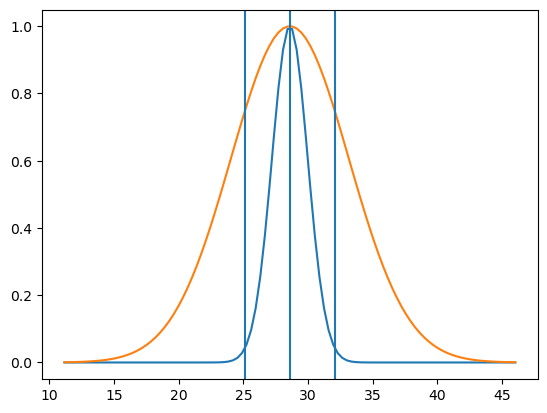

In [46]:
a, b, c, d = np.array([279.1666, 0.2962, -1.9701, 0.3681])
mass, radius, Teff = 1.14, 11.96, 4285
numax = mass * radius**-2. * (Teff/5777)**-0.5 * 3090.
Dnu = mass**0.5 * radius **-1.5 * 135.1

sig = a * mass**b * radius**c * (Teff/5777)**d 

freqs = np.linspace(numax-5*Dnu, numax+5*Dnu, 100)
weights = jnp.exp(-(freqs-numax)**2.0/sig**2.0) # (Nmodels, Nmodes)
plt.plot(freqs, weights)


k, b = 0.9638, -1.7145
width = np.exp(k*np.log(numax) + b)
weights = np.exp(-(freqs-numax)**2./(2*width**2.))
plt.plot(freqs, weights)


plt.axvline(numax)
plt.axvline(numax-Dnu)
plt.axvline(numax+Dnu)

In [37]:
idx = (stars['numax']<50) & (stars['KIC']==1164584)
stars.loc[idx,['numax', 'Dnu', 'RGBcorM', 'RGBcorR', 'Teff']]
# stars.columns.to_numpy()

,numax,Dnu,RGBcorM,RGBcorR,Teff
92,28.58,3.361,1.14,11.96,4285.0


In [40]:
# idx = modes['KIC']==1164584
# modes.loc[idx,:]

## compare two methods of calculating Dnu

In [89]:
sidx = (stars['ifmodelling']==True) 

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan, np.nan]
    f = h5py.File(filepath, 'r')
    idx = np.argmin(f['chi2'][:])
    
    fcs = f['mod_freq'][:][idx,:]
    numax = f['numax_scaling'][:][idx]
    mass = f['star_mass'][:][idx]
    radius = f['radius'][:][idx]
    Teff = f['Teff'][:][idx]

    # method 1 - Gaussian weighting
    a, b, c, d = np.array([279.1666, 0.2962, -1.9701, 0.3681])
    sig = a * mass**b * radius**c * (Teff/5777)**d
    weights = 1./(sig*(2*np.pi)**0.5) * np.exp(-(fcs-numax)**2.0/(2*sig**2.0))

    Nmodes = fcs.shape[0]
    X = np.concatenate([np.ones((Nmodes,1)), np.arange(Nmodes).reshape(-1,1)], axis=1)
    w = np.diagflat(weights)
    y = fcs.reshape(1,-1)

    Dnu_gw = (np.linalg.inv(X.T @ w @ X) @ ((X.T @ w @ y.T)))[1]

    # method 2 - local Dnu near numax
    aidx = np.argsort((fcs-numax)**2.0)
    Dnu_bc = np.abs(fcs[aidx[1]]-fcs[aidx[2]])/2.
    
    return [Dnu_gw, Dnu_bc]

r = process_map(multi, stars.loc[sidx,:].iterrows(), total=np.sum(sidx), max_workers=12)
stars.loc[sidx, ['Dnu_gw', 'Dnu_bc']] = np.array(r)

  0%|          | 0/1278 [00:00<?, ?it/s]

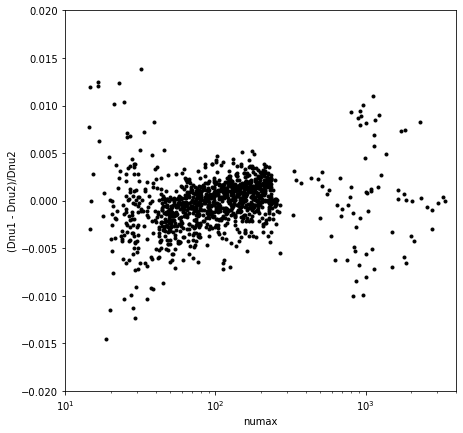

In [90]:
sidx = (stars['ifmodelling']==True)

data = stars.loc[sidx,['Dnu_gw', 'Dnu_bc', 'numax']].to_numpy()
y1, y2, x = data[:,0], data[:,1], data[:,2]
y = (y1-y2)/y2

fig, axes = plt.subplots(figsize=(7,7), ncols=1, nrows=1, squeeze=False)
axes = axes.reshape(-1)
axes[0].plot(x, y, 'k.')
axes[0].set_xlabel('numax')
axes[0].set_ylabel('(Dnu1 - Dnu2)/Dnu2')
axes[0].set_xlim(10,4000)
axes[0].set_ylim(-0.02, 0.02)
axes[0].set_xscale('log')

# a modelling code
## get quantities from the coarse grid

In [71]:
# def get_model_Dnu(mod_freq, Dnu, numax, mass, radius, Teff, mod_n, window=None):
#     # width estimates based on this work
#     a, b, c, d = np.array([279.1666, 0.2962, -1.9701, 0.3681])
#     sig = a * mass**b * radius**c * (Teff/5777)**d 
#     weights = 1./(sig*(2*np.pi)**0.5) * np.exp(-(mod_freq-numax)**2.0/(2*sig**2.0))

#     if window is not None:
#         idx = np.abs(mod_freq-numax)<(window*Dnu)
#         mod_freq, weights, mod_n = mod_freq[idx], weights[idx], mod_n[idx]
    
#     # method 1: use all modes
#     num = (-np.sum(weights*mod_n)*np.sum(weights*mod_freq) + \
#      np.sum(weights)*np.sum(weights*mod_n*mod_freq) )
#     den = (np.sum(weights)*np.sum(weights*mod_n**2.) - np.sum(weights*mod_n)**2. )
#     Dnu_mod = num/den
    
#     return Dnu_mod


def get_model_Dnu(mod_freq, mod_l, Dnu, numax, mod_n=None):
    # width estimates based on Yu+2018, Lund+2017, Li+2020
    k, b = 0.9638, -1.7145
    width = np.exp(k*np.log(numax) + b)

    # assign n
    l0 = mod_l==0
    mod_freq_l0 = np.copy(mod_freq)[l0]
    sidx = np.argsort(mod_freq_l0) 
    mod_freq_l0 = mod_freq_l0[sidx]
    mod_n = np.arange(len(mod_freq_l0)) if (mod_n is None) else np.copy(mod_n)[l0][sidx]
    # print(mod_n, mod_freq_l0)
    # sigma = 1/np.exp(-(mod_freq_l0-numax)**2./(2*width**2.))
    weight = np.exp(-(mod_freq_l0-numax)**2./(2*width**2.))
    idx = weight>1e-100
    if np.sum(idx)>2:
        p, _, _, _, _ = np.polyfit(mod_n[idx], mod_freq_l0[idx], 1, w=weight[idx], full=True)
        mod_Dnu, mod_eps = p[0], p[1]/p[0]
    else:
        mod_Dnu, mod_eps = np.nan, np.nan 

    return mod_Dnu

In [63]:
data = np.load('models/calibrated/tracks_8000_8192.npy', allow_pickle=True)

In [65]:
data.dtype

dtype([('index', '<f8'), ('profile_number', '<f8'), ('flag_seismo', '<i8'), ('star_age', '<f8'), ('star_mass', '<f8'), ('luminosity', '<f8'), ('radius', '<f8'), ('Teff', '<f8'), ('delta_nu_scaling', '<f8'), ('numax_scaling', '<f8'), ('acoustic_cutoff', '<f8'), ('delta_Pg', '<f8'), ('log_g', '<f8'), ('Yinit', '<f8'), ('Xinit', '<f8'), ('Zinit', '<f8'), ('center_h1', '<f8'), ('fov_core', '<f8'), ('fov_shell', '<f8'), ('amlt', '<f8'), ('FeH', '<f8'), ('log_LHe', '<f8'), ('log_Lnuc', '<f8'), ('density', '<f8'), ('numax', '<f8'), ('Dnu', '<f8'), ('[M/H]', '<f8'), ('mode_l', 'O'), ('mode_n', 'O'), ('mode_freq_o', 'O'), ('mode_freq', 'O'), ('mode_inertia', 'O'), ('Dnu_freq_o', '<f8'), ('eps_o', '<f8'), ('surf_corr_at_numax', '<f8')])

In [ ]:
files = [f for f in os.listdir('models/calibrated/') if f.endswith('npy')]

for file in files:
# file = files[0]

    filepath = 'models/calibrated/{:s}'.format(file)
    outpath = 'models/fDnu/{:s}.parquet'.format(file)

    f = np.load(filepath, allow_pickle=True)
    # idx = (f['phase'][:]>=0) & (10.0**(f['log_LHe'][:]-f['log_Lnuc'][:])<0.00001) & (f['flag_seismo'][:]==1)
    cols = [ 'amlt', 'Yinit', 'Zinit', 'numax_scaling','delta_nu_scaling', 
            'star_mass', 'star_age', 'FeH', 'radius', 'Teff', 
            'mode_freq_o', 'mode_freq', 'mode_n', 'mode_l', 'index', 'center_h1', ]
    data = pd.DataFrame(f[cols]) #np.array([f[col] for col in cols]).T, columns=cols
    Zsun, Xsun = 0.0134, 0.7381 # 0.0134, 0.7381, a09 # 0.0169, 0.7345, gs98
    data['surface_Z/X'] = 10.0**(data['FeH'] + np.log10(Zsun/Xsun)) 

    data['mass'] = data['star_mass']
    data['age'] = data['star_age']/1e9

    def multi(inputs):
        im, m = inputs

        numax_scaling = m['numax_scaling']
        Dnu_scaling = m['delta_nu_scaling']
        
        mode_freq_o = m['mode_freq_o']
        mode_freq = m['mode_freq']
        mode_l = m['mode_l']
        mode_n = m['mode_n']

        Dnu_freq_o = get_model_Dnu(mode_freq_o, mode_l, Dnu_scaling, numax_scaling, mode_n)
        Dnu_freq = get_model_Dnu(mode_freq, mode_l, Dnu_scaling, numax_scaling, mode_n)
        # Dnu_freq_t = get_model_Dnu(mode_freq, Dnu_scaling, numax_scaling, mass, radius, Teff, mode_n, window=3)

        return [Dnu_freq_o, Dnu_freq] #Dnu_freq_t

    r = process_map(multi, data.iterrows(), total=len(data), max_workers=14)
    data.loc[:, ['Dnu_freq_o', 'Dnu_freq']] = np.array(r) #, 'Dnu_freq_t'

    # cols = ['profile_number', 'delta_nu_scaling', 'numax_scaling', 'Dnu_freq_t']
    cols_keep = ['Teff', 'amlt', 'Yinit', 'Zinit', 'surface_Z/X', 'radius', 'mass', 'age', 'Dnu_freq', 'Dnu_freq_o', 'index', 'center_h1', ] 
    data[cols_keep].to_parquet(outpath)

  0%|          | 0/804732 [00:00<?, ?it/s]

  0%|          | 0/806777 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/803365 [00:00<?, ?it/s]

  0%|          | 0/803568 [00:00<?, ?it/s]

In [73]:
# merge all parquets
data = pd.concat([pd.read_parquet('models/fDnu/'+f) for f in os.listdir('models/fDnu/') if f.startswith('tracks')], 
                 join='outer', 
                 ignore_index=True, )

In [74]:
data.to_parquet('models/fDnu/fDnu_grid.parquet')

In [75]:
data = pd.read_parquet('models/fDnu/fDnu_grid.parquet')
data

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o,index,center_h1
0,5473.038775,1.539984,0.281014,0.004940,0.006918,0.721764,0.77866,0.043321,191.853138,194.258324,0.0,7.134670e-01
1,5466.737496,1.539984,0.281014,0.004940,0.006918,0.720247,0.77866,0.044788,192.444121,194.877970,0.0,7.134132e-01
2,5462.520256,1.539984,0.281014,0.004940,0.006918,0.719735,0.77866,0.046548,192.643821,195.094229,0.0,7.133479e-01
3,5460.155294,1.539984,0.281014,0.004940,0.006918,0.719967,0.77866,0.048659,192.550859,195.007745,0.0,7.132681e-01
4,5457.494477,1.539984,0.281014,0.004940,0.006918,0.721361,0.77866,0.054234,191.999750,194.457692,0.0,7.130516e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
6587248,3842.598494,1.473590,0.309145,0.028782,0.044494,13.031104,0.75376,38.000437,2.338914,2.425903,8191.0,0.000000e+00
6587249,3837.147782,1.473590,0.309145,0.028782,0.044494,13.216241,0.75376,38.001707,2.290099,2.376194,8191.0,0.000000e+00
6587250,3831.716272,1.473590,0.309145,0.028782,0.044494,13.401635,0.75376,38.002941,2.243241,2.328393,8191.0,2.243043e-46
6587251,3826.471624,1.473590,0.309145,0.028782,0.044494,13.587498,0.75376,38.004139,2.198178,2.282296,8191.0,0.000000e+00


In [44]:
# data.iloc[np.arange(0, len(data), 5)].reset_index(drop=True).to_parquet('models/fDnu/fDnu_grid_reduced.parquet')

In [118]:
# ls -lh models/fDnu/

## the solar properties (Dnu, rho) to be used in the fDnu equation

In [54]:
f = h5py.File('results_spec_gaia_nu_sc/0/data.h5', 'r')
f.keys()
bidx = np.argmin(f['chi2_classical'][:]+3*f['chi2_seismic'][:])
print('Dnu: {:.3f}'.format(f['Dnu_freq'][bidx]))
print('density: {:.3f}'.format(f['density'][bidx]))

Dnu: 134.979
density: 0.917


In [59]:
print(pd.read_csv('results_spec_gaia_nu_sc/0/summary_prob.txt').iloc[1][['Dnu_freq', 'density', 'radius', 'star_mass', 'numax_scaling', 'Teff', 'luminosity', 'amlt']])

Dnu_freq          134.979996
density             0.965166
radius              0.986914
star_mass           0.969090
numax_scaling    3059.626180
Teff             5825.295075
luminosity          0.998171
amlt                2.214814
Name: 1, dtype: float64


# fDnu

1. plot f_Dnu (Dnu_freq_o / density) vs. Teff and Dnu. 
The purporse is to check whether f_sharma is correct, despite the difference of input physics.

2. plot f_sc (Dnu_freq / Dnu_freq_o (before applying the prescriptions) ) vs. Teff and Dnu. 
The purpose is to advise how much more corrections are needed.

3. Fit a relation between f_sc and numax, Dnu, Teff ?

## use MIST model properties to calculate fDnu factors for S16 and this work
Based on MIST models, calculate the S16 factors with Sanjib's code, and our correction factors (Dnu 0.1%, numax 1%, Teff 1.5%) -> (mass 8%, radius 2%, Teff 80K).

In [5]:
# import importlib
import sys
sys.path.append('/Users/yaguang/Onedrive/github/ebfpy/')
from fdnu.asfgrid import Seism
import scaling
# importlib.reload(scaling)


masses = [1.0, 1.4, 1.8]
fehs = [-0.4, 0., 0.4]

mdata = [[[], [], []] for i in range(3)]
for imass in range(3):
    for ifeh in range(3):
        # read in MIST models
        g = se.MIST_EEP('mist/m{:0.0f}feh{:03.0f}.track.eep'.format(masses[imass]*10, fehs[ifeh]*10))
        
        idx = (g.eeps['phase']>=0) & (g.eeps['phase']<=2) & (g.eeps['delta_nu']>2)
        # 30
        idx = np.arange(len(g.eeps['phase']))[idx] #actual integer index
        Nstar = 200
        idx = idx[np.array(np.arange(0,Nstar,1)/Nstar*len(idx), dtype=int)]
        
        # get fDnu_o from S16
        #Nstar = np.sum(idx)
        evstate= np.ones(Nstar)
        logz = g.eeps['log_surf_z'][idx]
        #Z_solar=0.019
        mass = np.zeros(Nstar)+masses[imass]
        
        Teff = 10.0**g.eeps['log_Teff'][idx]
        logg = g.eeps['log_g'][idx]
        Dnu = g.eeps['delta_nu'][idx]
        radius = 10.0**g.eeps['log_R'][idx]
        density = mass * radius**-3.0
        numax = mass * radius**-2.0 * (Teff/5777)**-0.5 * 3090
        feh = np.zeros(Nstar)+fehs[ifeh]
        
        mdata[imass][ifeh] = pd.DataFrame(np.array([mass, radius, Teff, Dnu, feh, logg]).T, 
                    columns=['mass', 'radius', 'Teff', 'Dnu', 'feh', 'logg'])
        
data = pd.concat([tp2 for tp1 in mdata for tp2 in tp1], axis=0, ignore_index=True)
sobj = Seism(datadir='fdnu/')
_,_,fDnu= sobj.get_dnu_numax(np.ones(len(data)),data['feh'],data['Teff'],data['mass'],data['mass'],data['logg'],isfeh=True,fill_value=None)

data['fDnu_S16'] = fDnu

Reading in: mist/m10feh-04.track.eep
Reading in: mist/m10feh000.track.eep
Reading in: mist/m10feh004.track.eep
Reading in: mist/m14feh-04.track.eep
Reading in: mist/m14feh000.track.eep
Reading in: mist/m14feh004.track.eep
Reading in: mist/m18feh-04.track.eep
Reading in: mist/m18feh000.track.eep
Reading in: mist/m18feh004.track.eep
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'flo

In [87]:
# data = data.iloc[np.arange(0, len(data), 4)].reset_index(drop=True)

In [6]:
data

,mass,radius,Teff,Dnu,feh,logg,fDnu_S16
0,1.0,0.894493,6217.670194,165.743180,-0.4,4.534991,0.995338
1,1.0,0.894812,6215.954622,165.661774,-0.4,4.534682,0.995338
2,1.0,0.896031,6214.486288,165.337164,-0.4,4.533499,0.995338
3,1.0,0.897388,6214.580752,164.972336,-0.4,4.532185,0.995338
4,1.0,0.898007,6214.875516,164.805766,-0.4,4.531586,0.995338
...,...,...,...,...,...,...,...
1795,1.8,16.136158,4276.077287,2.987158,0.4,2.277422,NaN
1796,1.8,17.179734,4244.499404,2.721829,0.4,2.222975,NaN
1797,1.8,17.726859,4228.757393,2.598185,0.4,2.195736,NaN
1798,1.8,18.877227,4196.968447,2.367083,0.4,2.141106,NaN


In [7]:
# get fDnu and fDnu_o from this work
#e_mass = mass*0.05
#e_radius = radius*0.015

for i in range(0, 18):
    print(i)
    idx = (data.index > (i*100)) & (data.index <= ((i+1)*100-1) )
    mass, radius, Teff = data.loc[idx,'mass'].to_numpy(), data.loc[idx,'radius'].to_numpy(), data.loc[idx,'Teff'].to_numpy()
    Dnu, feh = data.loc[idx,'Dnu'].to_numpy(), data.loc[idx,'feh'].to_numpy()

    density = mass * radius**-3.0
    e_density = density*0.002
    numax = mass * radius**-2.0 * (Teff/5777)**-0.5 * 3090
    e_numax = numax * 0.01
    e_Teff = np.zeros(len(mass))+50

    s = scaling.seismo(path_grid_models='models/fDnu/fDnu_grid.parquet')
    s.set_observables(density=density, e_density=e_density, numax=numax, e_numax=e_numax, Teff=Teff, e_Teff=e_Teff)
    Dnu_freq, e_Dnu_freq = s._get_estimators('Dnu_freq')
    Dnu_freq_o, e_Dnu_freq_o = s._get_estimators('Dnu_freq_o')

    # Dnu_sun_model = 134.900665
    # density_sun_model = 0.961087
    # Dnu_sun_model = 134.8086
    # density_sun_model = 1.00132
    Dnu_sun_model = 135.0959
    density_sun_model = 1.00570

    fDnu = Dnu_freq/Dnu_sun_model*(density/density_sun_model)**-0.5
    e_fDnu = e_Dnu_freq/Dnu_sun_model*(density/density_sun_model)**-0.5
    fDnu_o = Dnu_freq_o/Dnu_sun_model*(density/density_sun_model)**-0.5
    e_fDnu_o = e_Dnu_freq_o/Dnu_sun_model*(density/density_sun_model)**-0.5

    # gdata = pd.DataFrame(
    #     np.array([mass, radius, feh, density, e_density, numax, e_numax, 
    #               fDnu, e_fDnu, fDnu_o, e_fDnu_o, Teff, e_Teff, 
    #               Dnu, Dnu_freq, e_Dnu_freq, Dnu_freq_o, e_Dnu_freq_o]).T, 
    #     columns=['mass', 'radius', 'feh', 'density', 'e_density', 'numax', 'e_numax', 
    #              'fDnu', 'e_fDnu', 'fDnu_o', 'e_fDnu_o', 'Teff', 'e_Teff', 
    #              'Dnu', 'Dnu_freq', 'e_Dnu_freq', 'Dnu_freq_o', 'e_Dnu_freq_o']
    # )

    data.loc[idx,'fDnu'], data.loc[idx,'e_fDnu'], data.loc[idx,'fDnu_o'], data.loc[idx,'e_fDnu_o'] = fDnu, e_fDnu, fDnu_o, e_fDnu_o,
    data.loc[idx,'Dnu_freq'], data.loc[idx,'e_Dnu_freq'], data.loc[idx,'Dnu_freq_o'], data.loc[idx,'e_Dnu_freq_o'] = Dnu_freq, e_Dnu_freq, Dnu_freq_o, e_Dnu_freq_o

0
1
2
3
4
5
6
7
8
9
10
11


/import/silo3/yali4742/numax-sc-metallicity/surface/scaling.py:128: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[-1]


12
13
14
15
16
17


In [8]:
data.to_parquet('data/fDnu_on_tracks_data.parquet')

In [9]:
data = pd.read_parquet('data/fDnu_on_tracks_data.parquet')

In [10]:
data

,mass,radius,Teff,Dnu,feh,logg,fDnu_S16,fDnu,e_fDnu,fDnu_o,e_fDnu_o,Dnu_freq,e_Dnu_freq,Dnu_freq_o,e_Dnu_freq_o
0,1.0,0.894493,6217.670194,165.743180,-0.4,4.534991,0.995338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.894812,6215.954622,165.661774,-0.4,4.534682,0.995338,0.986639,0.002262,0.992310,0.002236,157.024999,0.359965,157.927485,0.355851
2,1.0,0.896031,6214.486288,165.337164,-0.4,4.533499,0.995338,0.985908,0.003118,0.991239,0.002956,156.588491,0.495181,157.435283,0.469547
3,1.0,0.897388,6214.580752,164.972336,-0.4,4.532185,0.995338,0.985762,0.003595,0.991076,0.003321,156.210327,0.569736,157.052445,0.526312
4,1.0,0.898007,6214.875516,164.805766,-0.4,4.531586,0.995338,0.986345,0.003599,0.991985,0.003325,156.141199,0.569738,157.033996,0.526320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,1.8,16.136158,4276.077287,2.987158,0.4,2.277422,NaN,0.964528,0.003224,0.993278,0.008753,2.689421,0.008989,2.769586,0.024408
1796,1.8,17.179734,4244.499404,2.721829,0.4,2.222975,NaN,0.963597,0.002639,0.993423,0.010606,2.445768,0.006698,2.521469,0.026920
1797,1.8,17.726859,4228.757393,2.598185,0.4,2.195736,NaN,0.961319,0.003320,0.995716,0.009524,2.327899,0.008039,2.411194,0.023064
1798,1.8,18.877227,4196.968447,2.367083,0.4,2.141106,NaN,0.960669,0.002492,0.993737,0.010241,2.116950,0.005491,2.189821,0.022567


## the solar properties (Dnu, rho) to be used in the fDnu equation

In [45]:
# use our own tracks to provide self-consistency
models = pd.read_parquet('models/fDnu/fDnu_grid.parquet')

In [46]:
models['lum'] = models['radius']**2.0 * (models['Teff']/5777.)**4.0 
models['density'] = models['mass'] * models['radius']**-3.0
models['grav'] = models['mass'] * models['radius']**-2.
models['numax'] = models['grav'] * (models['Teff']/5777)**-0.5 * 3090.

Dnu_sun_model = 135.0959
density_sun_model = 1.00570

models['fDnu'] = (models['Dnu_freq']/Dnu_sun_model * (models['mass'] * models['radius']**-3.0/density_sun_model)**-0.5).to_numpy()


chi2 = (((models['lum']-1.0)/0.02)**2. + \
        ((models['Teff']-5777)/50)**2. + \
        ((np.log10(models['surface_Z/X'])-np.log10(0.0181547))/0.05)**2. +
        ((models['Dnu_freq']-135.1)/0.1)**2. ).to_numpy()

In [47]:
def _quantile(x, q, weights):
    idx = np.argsort(x)
    sw = weights[idx]
    cdf = np.cumsum(sw)[:-1]
    cdf /= cdf[-1]
    cdf = np.append(0, cdf)
    return np.interp(q, cdf, x[idx])

In [48]:
print(_quantile(models['Dnu_freq'], 0.5, np.exp(-chi2/2)), _quantile(models['density'], 0.5, np.exp(-chi2/2)))

135.09739116194052 1.0057092778004106


In [ ]:
models.columns

## fDnu this work

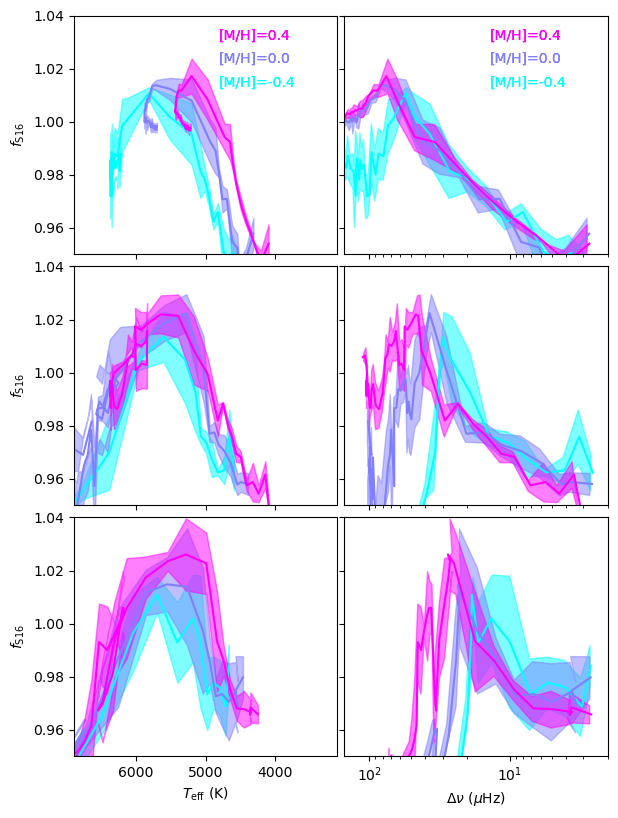

In [169]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.4,vmax=0.4)


fig, axes = plt.subplots(figsize=[6,8], nrows=3, ncols=2, 
                         squeeze=False, constrained_layout=True)
# axes = axes.reshape(-1)


styles = {'marker':'.', 's':4, 'norm':norm, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}


# mass_ranges = [[0.8, 1.2], [1.2, 1.6], [1.6, 2.0]]
for irow, mass in enumerate([1.0, 1.4, 1.8]):
#     idx = (stars['mass_micp']>mass_ranges[irow][0]) & (stars['mass_micp']<mass_ranges[irow][1])
#     axes[irow,0].scatter(stars.loc[idx,'Teff'], stars.loc[idx,'Dnu_freq_o_micp']/135.1*stars.loc[idx,'density_micp']**-0.5,
#                          c=stars.loc[idx,'[M/H]'],
#                          **styles)
#     axes[irow,1].scatter(stars.loc[idx,'Dnu_freq_o_micp'], stars.loc[idx,'Dnu_freq_o_micp']/135.1*stars.loc[idx,'density_micp']**-0.5, 
#                          c=stars.loc[idx,'[M/H]'],
#                          **styles)
    
#     axes[irow,1].scatter(stars.loc[idx,'Dnu_freq_o_micp'], stars.loc[idx,'fdnu'], 
#                          c=stars.loc[idx,'[M/H]'],
#                          **styles)
    
    for ifeh, feh in enumerate([-0.4, 0., 0.4]):
        t = data[(data['mass']==mass) & (data['feh']==feh)]
        axes[irow,0].plot(t['Teff'], t['fDnu'], color=plt.cm.cool(norm(t['feh'].iloc[0])))
        axes[irow,1].plot(t['Dnu']*t['fDnu'], t['fDnu'], color=plt.cm.cool(norm(t['feh'].iloc[0])))
        
        # data = gdata[irow][ifeh]
        axes[irow,0].fill_between(t['Teff'], t['fDnu']-t['e_fDnu'], t['fDnu']+t['e_fDnu'], 
                                  color=plt.cm.cool(norm(t['feh'].iloc[0])), alpha=0.5)
        axes[irow,1].fill_between(t['Dnu'], t['fDnu']-t['e_fDnu'], t['fDnu']+t['e_fDnu'], 
                                  color=plt.cm.cool(norm(t['feh'].iloc[0])), alpha=0.5)
#         axes[irow,0].plot(data['Teff'], data['fdnu'], color=plt.cm.cool(norm(data['feh'].iloc[0])), linestyle='--')
#         axes[irow,1].plot(data['Dnu']*data['fdnu'], data['fdnu'], color=plt.cm.cool(norm(data['feh'].iloc[0])), linestyle='--')
        
    axes[irow,0].set_xlim(6900, 3100)
    axes[irow,1].set_xlim(150., 2.)
    axes[irow,1].set_xscale('log')
    
    if irow<2:
        axes[irow,0].set_xticklabels([])
        axes[irow,1].set_xticklabels([])

    axes[irow,1].set_yticklabels([])
    axes[irow,0].set_ylabel('$f_{\\rm S16}$')
    
    axes[irow,0].set_ylim(0.95, 1.04)
    axes[irow,1].set_ylim(0.95, 1.04)
    
    for icol in range(2):
        axes[0,icol].text(0.55, 0.9, '[M/H]=0.4', color=plt.cm.cool(norm(0.4)), transform=axes[0,icol].transAxes, ha='left' )
        axes[0,icol].text(0.55, 0.8, '[M/H]=0.0', color=plt.cm.cool(norm(0.)), transform=axes[0,icol].transAxes, ha='left' )
        axes[0,icol].text(0.55, 0.7, '[M/H]=-0.4', color=plt.cm.cool(norm(-0.4)), transform=axes[0,icol].transAxes, ha='left' )
        # axes[irow,icol].text(0.05, 0.1,'{:0.1f} M$_\\odot$'.format(np.mean(mass_ranges[irow])), transform=axes[irow,icol].transAxes, ha='left')

axes[-1,0].set_xlabel('$T_{\\rm eff}$ (K)')
axes[-1,1].set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)')

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)


# filename = 'Fig8_fs16.pdf'

# plt.savefig(filename)
# os.system(to_overleaf(filename, 'figures'))

In [170]:
data.columns

Index(['mass', 'radius', 'Teff', 'Dnu', 'feh', 'logg', 'fDnu_S16', 'fDnu',
       'e_fDnu', 'fDnu_o', 'e_fDnu_o', 'Dnu_freq', 'e_Dnu_freq', 'Dnu_freq_o',
       'e_Dnu_freq_o'],
      dtype='object')

## fDnu this work vs fDnu_o this work vs fDnu_S16

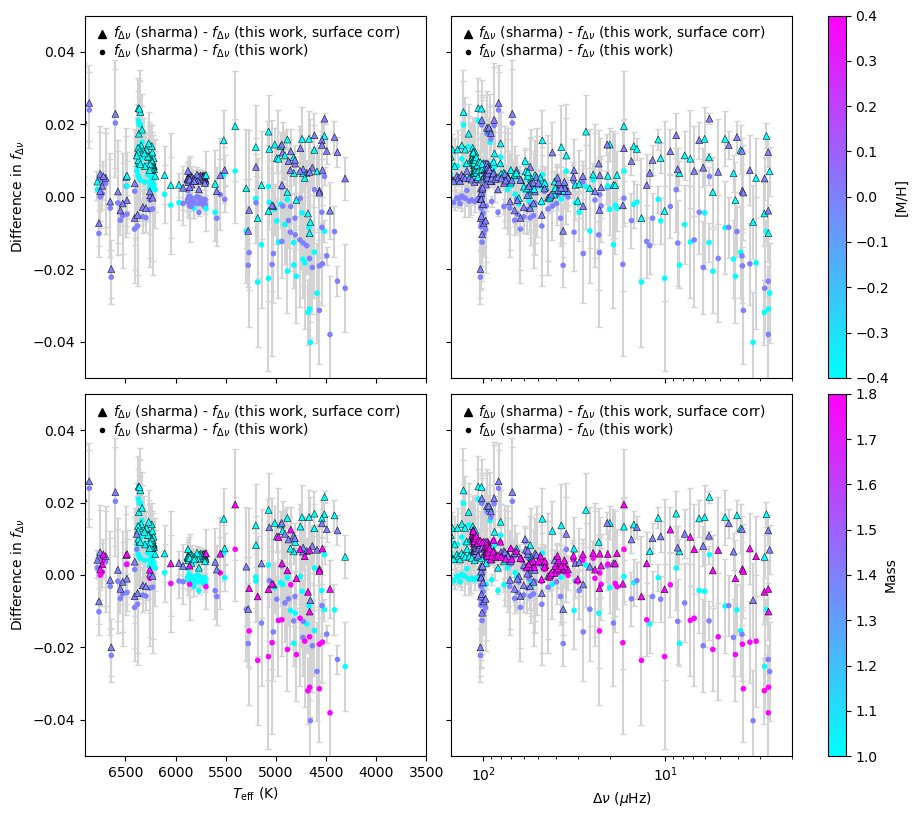

In [174]:
import matplotlib.colors
norm1 = matplotlib.colors.Normalize(vmin=-0.4,vmax=0.4)
norm2 = matplotlib.colors.Normalize(vmin=1.0,vmax=1.8)
cmap = 'cool'
fig, axes = plt.subplots(figsize=[9,8], nrows=2, ncols=2, 
                         squeeze=False, constrained_layout=True)
# axes = axes.reshape(-1)


styles = {'marker':'.', 's':4, 'norm':norm, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}


for irow, [norm, zval] in enumerate([[norm1, 'feh'], [norm2, 'mass']]):
    axes[irow,0].scatter(data['Teff'], data['fDnu_S16']-data['fDnu_o'], c=data[zval], 
                         norm=norm, cmap=cmap, marker='.')
    axes[irow,1].scatter(data['Dnu'], data['fDnu_S16']-data['fDnu_o'], c=data[zval], 
                         norm=norm, cmap=cmap, marker='.')
    axes[irow,0].errorbar(data['Teff'], data['fDnu_S16']-data['fDnu_o'], yerr=data['e_fDnu_o'],
                          ecolor='lightgray', capsize=2, linestyle='none', zorder=-10)
    axes[irow,1].errorbar(data['Dnu'], data['fDnu_S16']-data['fDnu_o'], yerr=data['e_fDnu_o'],
                          ecolor='lightgray', capsize=2, linestyle='none', zorder=-10)


    axes[irow,0].scatter(data['Teff'], data['fDnu_S16']-data['fDnu'], c=data[zval], 
                         norm=norm, cmap=cmap, marker='^', edgecolor='k', linewidths=0.35, s=25)
    axes[irow,1].scatter(data['Dnu'], data['fDnu_S16']-data['fDnu'], c=data[zval], 
                         norm=norm, cmap=cmap, marker='^', edgecolor='k', linewidths=0.35, s=25)
    axes[irow,0].errorbar(data['Teff'], data['fDnu_S16']-data['fDnu'], yerr=data['e_fDnu'],
                          ecolor='lightgray', capsize=2, linestyle='none', zorder=-10)
    axes[irow,1].errorbar(data['Dnu'], data['fDnu_S16']-data['fDnu'], yerr=data['e_fDnu'],
                          ecolor='lightgray', capsize=2, linestyle='none', zorder=-10)
        
        
for irow in range(2):
    axes[irow,0].set_xlim(6900, 3500)
    axes[irow,1].set_xlim(150., 2.)
    axes[irow,1].set_xscale('log')
    
    if irow<1:
        axes[irow,0].set_xticklabels([])
        axes[irow,1].set_xticklabels([])

    axes[irow,1].set_yticklabels([])
    axes[irow,0].set_ylabel('Difference in $f_{\\Delta\\nu}$')

    axes[irow,0].set_ylim(-0.05, 0.05)
    axes[irow,1].set_ylim(-0.05, 0.05)
    
    for icol in range(2):
        axes[irow,icol].plot([0.05],[0.95], marker='^', transform=axes[irow,icol].transAxes, color='k')
        axes[irow,icol].text(0.08,0.95, '$f_{\\Delta\\nu}$ (sharma) - $f_{\\Delta\\nu}$ (this work, surface corr)', transform=axes[irow,icol].transAxes, color='k', va='center')

        axes[irow,icol].plot([0.05],[0.90], marker='.', transform=axes[irow,icol].transAxes, color='k')
        axes[irow,icol].text(0.08,0.90, '$f_{\\Delta\\nu}$ (sharma) - $f_{\\Delta\\nu}$ (this work)', transform=axes[irow,icol].transAxes, color='k', va='center')

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axes[0,:]).set_label('[M/H]')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm2, cmap=cmap), ax=axes[1,:]).set_label('Mass')

axes[-1,0].set_xlabel('$T_{\\rm eff}$ (K)')
axes[-1,1].set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)')

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)


# filename = 'Fig8_fs16.pdf'

# plt.savefig(filename)
# os.system(to_overleaf(filename, 'figures'))

# a fitting relation

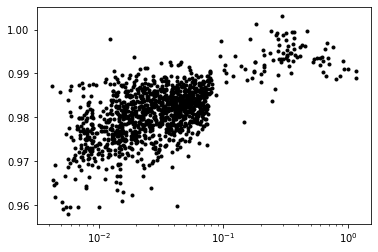

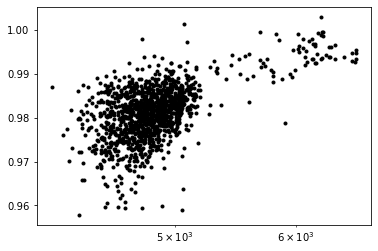

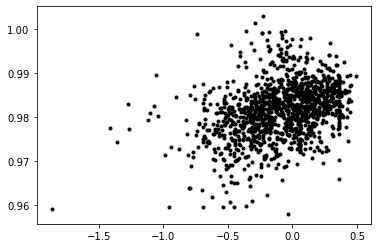

In [15]:
stars['fsc'] = stars['Dnu_freq_micp']/stars['Dnu_freq_o_micp']
idx = (stars['fsc']<1.05) & (stars['fsc']>0.95)
plt.figure()
plt.plot(stars.loc[idx,'g_micp'], stars.loc[idx,'fsc'], 'k.')
plt.xscale('log')

plt.figure()
plt.plot(stars.loc[idx,'Teff'], stars.loc[idx,'fsc'], 'k.')
plt.xscale('log')

plt.figure()
plt.plot(stars.loc[idx,'[M/H]'], stars.loc[idx,'fsc'], 'k.')

In [11]:
stars['f'] = stars['Dnu_freq_micp']/135.1*stars['density_micp']**-0.5
stars['e_f'] = stars['f'] * ((stars['e_Dnu_freq_micp']/stars['Dnu_freq_micp'])**2.0 + \
                                0.5*(stars['e_density_micp']/stars['density_micp'])**2.0 )**0.5

In [12]:
stars[['numax', 'Dnu', 'Teff', '[M/H]', 'Dnu_freq_micp', 'f']]

,numax,Dnu,Teff,[M/H],Dnu_freq_micp,f
0,1216.000000,64.200000,5560.0,0.280000,64.343197,1.014679
1,1094.737247,61.506825,5588.0,-0.091143,61.593160,1.012253
2,1004.011175,56.009512,6018.0,-0.239279,56.036588,1.010732
3,676.612868,40.393149,5451.0,-0.110000,40.436064,1.005069
4,684.062455,41.020573,4956.0,0.200000,41.034824,0.991551
...,...,...,...,...,...,...
1271,76.700000,NaN,5007.0,-0.490000,7.084179,0.963467
1272,38.220000,NaN,4674.0,-0.300000,4.235558,0.953081
1273,27.070000,3.122528,4612.0,-0.330000,3.153463,0.948432
1274,63.700000,6.217648,4864.0,-0.230000,6.290997,0.957234


0.8343466873604345
0.8885915208305342
betas: np.array([4.0148, 0.1683, -0.1857, -10.2337, 11.4320, -4.2004, 0.0015])
Verification from linear algebra: np.array([4.015, 0.168, -0.186, -10.234, 11.432, -4.200, 0.001])
SE(beta_hat[0]): 0.225
SE(beta_hat[1]): 0.012
SE(beta_hat[2]): 0.015
SE(beta_hat[3]): 0.735
SE(beta_hat[4]): 0.801
SE(beta_hat[5]): 0.290
SE(beta_hat[6]): 0.001


/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


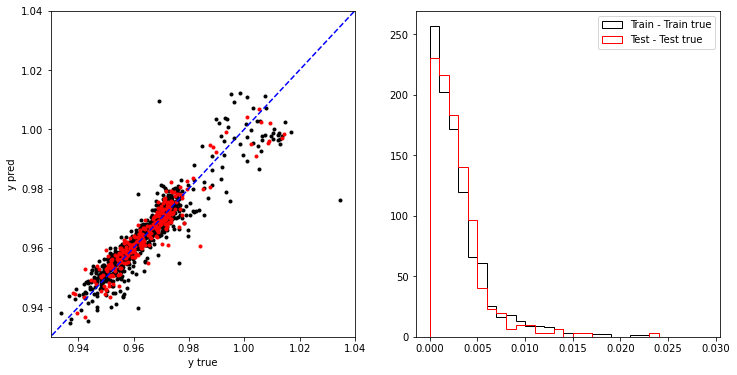

In [80]:
from sklearn.model_selection import train_test_split

# sample = stars.dropna(subset=['mass_micp', 'radius_micp', 'Teff', '[M/H]', 'fsc'] ).reset_index(drop=True)
# X = sample[['mass_micp', 'radius_micp', 'Teff', '[M/H]']].to_numpy()

sample = stars.dropna(subset=['numax', 'Dnu', 'Teff', '[M/H]', 'f'] ).reset_index(drop=True)
sample = sample[sample['[M/H]']>-0.8].reset_index(drop=True)
cols = ['numax', 'Dnu', 'Teff',  '[M/H]']
sample['numax'] = sample['numax']/3090
sample['Dnu'] = sample['Dnu']/135.1
sample['Teff'] = sample['Teff']/5777.
for col in cols:
    sample[col+'^1'] = sample[col]**1.
    sample[col+'^2'] = sample[col]**2.
    sample[col+'^3'] = sample[col]**3.
    sample[col+'^4'] = sample[col]**4.
X = sample[['numax', 'Dnu', 'Teff', 'Teff^2', 'Teff^3', '[M/H]']].to_numpy()
X[:,0:2] = np.log10(X[:,0:2])
# X[:,0:3] = np.log10(X[:,0:3])
# X[:,0:4] = np.log10(X[:,0:4])

y = sample['f'].to_numpy()
e_y = sample['e_f'].to_numpy()
X_train, X_test, y_train, y_test, e_y_train, e_y_test = train_test_split(X, y, e_y, test_size=0.25, random_state=1)

regr = LinearRegression().fit(X_train, y_train)

y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

print('betas: np.array([{:s}])'.format(', '.join(['{:0.4f}'.format(f) for f in np.concatenate([[regr.intercept_],regr.coef_])] )))


N = len(X_train)
p = X_train.shape[1] + 1
X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X_train
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y_train
print('Verification from linear algebra: np.array([{:s}])'.format(', '.join(['{:0.3f}'.format(f) for f in beta_hat ])))
residuals = y_train - y_train_pred
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print("SE(beta_hat[{}]): {:.3f}".format(p_, standard_error))

fig, axes = plt.subplots(figsize=[12,6], nrows=1, ncols=2, squeeze=False)
axes = axes.reshape(-1)
# plt.plot(stars['fdnu'], stars['Dnu_freq_o_micp']/135.1*stars['density_micp']**-0.5, 'k.')
axes[0].plot(y_train, y_train_pred, 'k.')
axes[0].plot(y_test, y_test_pred, 'r.')
axes[0].axis([0.93,1.04,0.93,1.04])
axes[0].plot([0.1,10.],[0.1,10.], 'b--')
axes[0].set_xlabel('y true')
axes[0].set_ylabel('y pred')

bins = np.arange(0., 0.03, 0.001)
axes[1].hist(np.abs(y_train-y_train_pred), bins=bins, color='k', histtype='step', label='Train - Train true', density=True)
axes[1].hist(np.abs(y_test-y_test_pred), bins=bins, color='r', histtype='step', label='Test - Test true', density=True)
axes[1].legend()
# axes[1].hist(sample['e_f'], bins=bins, color='b', histtype='step')

In [55]:
import emcee

def log_prob(thetas):
    # thetas: (Ndim
    betas = thetas.reshape(-1,1)
    X = np.hstack([np.ones((X_train.shape[0],1)), X_train])
    y = X @ betas
    return -0.5 * np.sum((y - y_train)**2./e_y_train**2.0)
    
nwalkers, ndim = 32, X_train.shape[1]+1
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
p0 = np.array([4.1027, 0.1706, -0.1863, -10.5526, 11.8359, -4.3733, 0.0015]) + np.random.rand(nwalkers, ndim)
state = sampler.run_mcmc(p0, 100, progress=True)

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


In [59]:
# samples = sampler.get_chain(flat=True, discard=10)
# corner.corner(samples);

# params = np.percentile(samples, [16, 50, 84], axis=0)
# betas = params[1,:]
# e_betas = (params[2,:]-params[0,:])/2

# print(betas)
# print(e_betas)

Text(0.5, 0, 'f this work - f sharma')

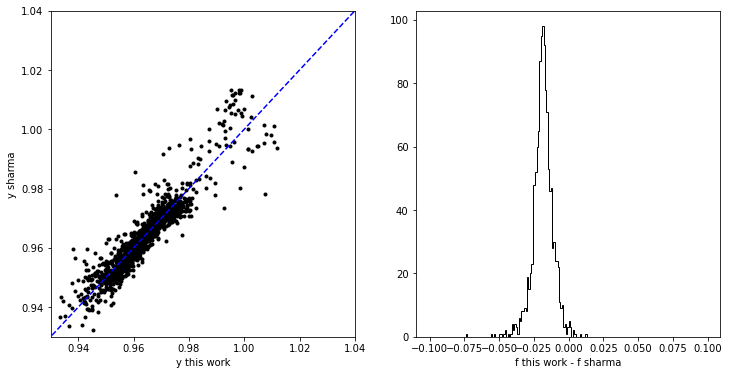

In [19]:
betas = np.array([4.1027, 0.1706, -0.1863, -10.5526, 11.8359, -4.3733, 0.0015])

numax = stars['numax'].to_numpy()/3090
Dnu = stars['Dnu'].to_numpy()/135.1
Teff = stars['Teff'].to_numpy()/5777.
Teff2 = Teff**2.
Teff3 = Teff**3.
mh = stars['[M/H]'].to_numpy()
X = np.array([np.log10(numax),  np.log10(Dnu), Teff,  Teff2,  Teff3,  mh]).T 
stars['fpred'] = np.sum(X*betas[1:].reshape(1,-1), axis=1) + betas[0]

fig, axes = plt.subplots(figsize=[12,6], nrows=1, ncols=2, squeeze=False)
axes = axes.reshape(-1)
# plt.plot(stars['fdnu'], stars['Dnu_freq_o_micp']/135.1*stars['density_micp']**-0.5, 'k.')
axes[0].plot(stars['fpred'], stars['f'], 'k.')
# axes[0].plot(stars['fpred'], stars['fdnu'], 'k.')
axes[0].axis([0.93,1.04,0.93,1.04])
axes[0].plot([0.1,10.],[0.1,10.], 'b--')
axes[0].set_xlabel('y this work')
axes[0].set_ylabel('y sharma')

bins = np.arange(-0.1, 0.1, 0.001)
axes[1].hist(stars['f']-stars['fdnu'], bins=bins, color='k', histtype='step')
axes[1].set_xlabel('f this work - f sharma')

0.7502142692400842
0.7310902899036695


(array([415., 114., 128., 112., 106.,  94.,  76.,  60.,  37.,  31.,  21.,
         17.,   4.,   5.,   0.,   2.,   2.,   2.,   1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
 [<matplotlib.patches.Polygon at 0x7febf0c3e150>])

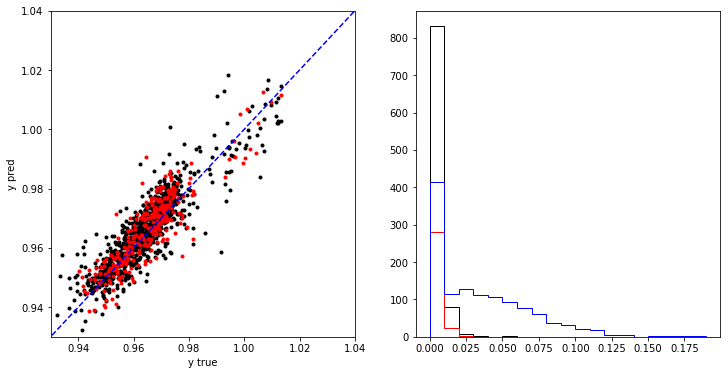

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# sample = stars.dropna(subset=['mass_micp', 'radius_micp', 'Teff', '[M/H]', 'fsc'] ).reset_index(drop=True)
# X = sample[['mass_micp', 'radius_micp', 'Teff', '[M/H]']].to_numpy()

sample = stars.dropna(subset=['numax', 'Dnu', 'Teff', '[M/H]', 'f'] ).reset_index(drop=True)
cols = ['numax', 'Dnu', 'Teff',  '[M/H]']
sample['numax'] = sample['numax']/3090
sample['Dnu'] = sample['Dnu']/135.1
sample['Teff'] = sample['Teff']/5777.
for col in cols:
    sample[col+'^2'] = sample[col]**2.
    sample[col+'^3'] = sample[col]**3.
    sample[col+'^4'] = sample[col]**4.
    
X = sample[['numax',  'Dnu',  'Teff', 'Teff^2', 'Teff^3', '[M/H]']].to_numpy()
X[:,0:3] = np.log10(X[:,0:3])
y = sample['f'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

regr = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), random_state=1, max_iter=500).fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))


fig, axes = plt.subplots(figsize=[12,6], nrows=1, ncols=2, squeeze=False)
axes = axes.reshape(-1)
# plt.plot(stars['fdnu'], stars['Dnu_freq_o_micp']/135.1*stars['density_micp']**-0.5, 'k.')
axes[0].plot(y_train, y_train_pred, 'k.')
axes[0].plot(y_test, y_test_pred, 'r.')
axes[0].axis([0.93,1.04,0.93,1.04])
axes[0].plot([0.1,10.],[0.1,10.], 'b--')
axes[0].set_xlabel('y true')
axes[0].set_ylabel('y pred')

bins = np.arange(0., 0.2, 0.01)
axes[1].hist(np.abs(y_train-y_train_pred), bins=bins, color='k', histtype='step')
axes[1].hist(np.abs(y_test-y_test_pred), bins=bins, color='r', histtype='step')
axes[1].hist(sample['e_f'], bins=bins, color='b', histtype='step')

In [ ]:
Z_X_sun=0.0181547
# Z+X+Y = 1
Y_sun = 0.2485 #0.249
X_sun = (1-Y_sun)/(Z_X+1)
Z_sun = 1-X_sun-Y_sun

Yp = 0.22
dY_dZ = (Y_sun-Yp)/Z_sun
dY_dZ
# Y = Yp+dY_dZ*Z

# Literature comparison

## compare with Tanda's models

The conclusion is that the masses and radii from Tanda's paper are similarly larger than Yu+18's seismic masses and radii (by 8% and 4% respectively). From Fig.10 of the paper, I believe it originates from revising fDnu. The discrepency is in quantative agreement as those in my paper.

In [22]:
yu = pd.read_csv('../../database/catalog/yu+2018.csv')
lit = pd.read_excel('../../database/catalog/litd++2022-rgb.xlsx').merge(yu[['KIC','RGBcorR','RGBcorM']], on='KIC', how='left')

(-30.0, 30.0)

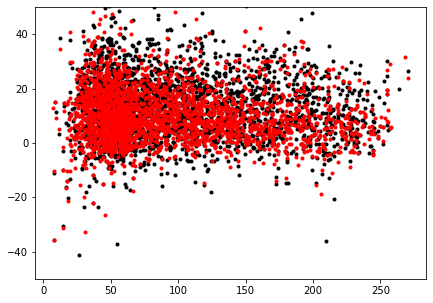

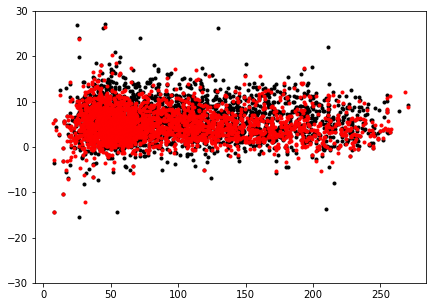

In [24]:
idx1 = lit['Source']=='LAMOST'
idx2 = lit['Source']=='APOGEE'
          
plt.figure(figsize=[7,5])
plt.plot(lit.loc[idx1,'numax'], (lit.loc[idx1,'RGBcorM']-lit.loc[idx1,'mass'])/lit.loc[idx1,'mass']*100, 'k.')
plt.plot(lit.loc[idx2,'numax'], (lit.loc[idx2,'RGBcorM']-lit.loc[idx2,'mass'])/lit.loc[idx2,'mass']*100, 'r.')
plt.ylim(-50, 50)

plt.figure(figsize=[7,5])
plt.plot(lit.loc[idx1,'numax'], (lit.loc[idx1,'RGBcorR']-lit.loc[idx1,'radius'])/lit.loc[idx1,'radius']*100, 'k.')
plt.plot(lit.loc[idx2,'numax'], (lit.loc[idx2,'RGBcorR']-lit.loc[idx2,'radius'])/lit.loc[idx2,'radius']*100, 'r.')
plt.ylim(-30, 30)

## compare with Dennis models

See how much does input physics plays a role.

In [25]:
track_params = pd.read_fwf('/import/extend2/stello/MESA6950/mysanjibgrid1001-1247_Z_Mass_crossref.txt')
files = pd.read_csv('dennis_filenames.csv')['filenames'].to_numpy()

In [26]:
files_grid_index = np.array([int(s.split('Grid')[1].split('_M')[0]) for s in files])
files_model_index = np.array([int(s.split('model')[1].split('.txt')[0]) for s in files])
# files_model_index
files = pd.DataFrame(np.array([files, files_grid_index, files_model_index]).T, columns=['filenames','GRID','model_number'])

In [132]:
idx = track_params['Mass']==1
track_params.loc[idx,:]

,GRID,Z,Mass
10,1011,0.000019,1.0
29,1030,0.000190,1.0
48,1049,0.000756,1.0
67,1068,0.001199,1.0
86,1087,0.001900,1.0
105,1106,0.003011,1.0
124,1125,0.004773,1.0
143,1144,0.007564,1.0
162,1163,0.011988,1.0
181,1182,0.019000,1.0


In [186]:
from grid import get_model_Dnu
import scipy 

idx = track_params['Mass']==1
# track_params.loc[idx,:]

for itrack, track in track_params.loc[idx,:].iterrows():
    filepath_h = '/import/extend2/stello/MESA6950/MySanjibGrid{:04.0f}/LOGS/history.data'.format(track['GRID'])
    filepath_p = '/import/extend2/stello/MESA6950/MySanjibGrid{:04.0f}/LOGS/profiles.index'.format(track['GRID'])
    if (not os.path.exists(filepath_h)) or (not os.path.exists(filepath_p)): continue 
    h = pd.read_fwf(filepath_h, skiprows=5, infer_nrows=1000)
    p = pd.read_fwf(filepath_p, skiprows=1, names=['model_number', 'priority', 'profile_number'], infer_nrows=1000)
    
    h = h.merge(p, how='inner', on='model_number')
    
    # h['diff_Dnu'] = np.diff(h['delta_nu'], append=0)
    # h['diff_Dnu2'] = np.diff(np.diff(h['delta_nu'], append=0), prepend=0)

    # idx = ((h['star_age']/1e9)>0.05) & (h['effective_T']<5500) & (h['diff_Dnu']>0) #& (h['delta_nu']>2)
    # newh = h.loc[idx,:].reset_index(drop=False)
    # max_index = newh[newh['diff_Dnu2']<0]['index'].iloc[0]

    idx = ((h['star_age']/1e9)>0.05)  & (h['delta_nu']>2.3) #& (h.index < max_index) #< (newh[newh < maxlum].sort_values('luminosity', ascending=False).index[0])

    h = h.loc[idx,:].reset_index(drop=True).merge(files[files['GRID']==track['GRID']], on='model_number')
    
    Zinit = track_params[track_params['GRID']==track['GRID']]['Z'].iloc[0]
    Yinit = 0.24 + 2*Zinit
    Xinit = 1-Zinit-Yinit
    h['Yinit'] = Yinit
    h['Zinit'] = Zinit
    h['Xinit'] = 1-Yinit-Zinit
    h['[M/H]'] = np.log10(Zinit/Xinit) - np.log10(0.0268) 
    if np.log10(Zinit/Xinit) - np.log10(0.0268) <-1.: continue
    
    # get files with grid index
    for ih, m in h.loc[:,:].iterrows(): 
        # grid_number = track['GRID']
        # mass = track['Mass']
        # z = track['Z']
        # model_number = m['profile_number']
        filepath = "/import/extend2/stello/GYRE31/ModelsFromSanjibGrid/"+m['filenames']
        s = pd.read_fwf(filepath, skiprows=4)
        # s[['Re(freq)', 'E_norm']]

        mass = m['star_mass']
        radius = m['photosphere_r']
        Teff = m['effective_T']
    
        feh = m['[M/H]']
        
        numax_scaling = mass * radius**-2. * (Teff/5777)**-0.5 * 3090.
        Dnu_scaling = mass**0.5 * radius**-1.5 * 135.1
        g = mass * radius**-2.

        k, b = 0.9638, -1.7145
        width = np.exp(k*np.log(numax_scaling)+b)
        idx = (s['Re(freq)']> (numax_scaling-3*width)) & (s['Re(freq)'] < (numax_scaling+3*width))
        mode_l = s.loc[idx,'l'].to_numpy()
        mode_n = s.loc[idx,'n_pg'].to_numpy()
        mode_freq_o = s.loc[idx,'Re(freq)'].to_numpy()
        mode_inertia = s.loc[idx,'E_norm'].to_numpy()

        Dnu_freq_o, _ = get_model_Dnu(mode_freq_o, mode_l, Dnu_scaling, numax_scaling, mode_n)
        
        """
        rgb = (Teff<5600) and (numax_scaling<250)

        if rgb:
            thetas = np.array([-3.6188, 1.1399, -10.8323, -1.5517, -4.7092, 1.0893, -9.7202, -1.4323])
        else:
            thetas = np.array([-5.2668, 0.8867, 1.4682, 0.9762, -7.1779, 0.9841, 0.9055, 0.7911])

        D1 = thetas[0] * (g)**thetas[1] * (Teff/5777.)**thetas[2] * (thetas[3]*feh + 1) # surf corr at numax
        D2 = thetas[4] * (g)**thetas[5] * (Teff/5777.)**thetas[6] * (thetas[7]*feh + 1) # surf corr at scale*numax
        scale = 1.1

        fi = scipy.interpolate.interp1d(mode_freq_o, (mode_freq_o/numax_scaling)**3.0/mode_inertia, kind='cubic')
        gs = fi(numax_scaling)

        fi = scipy.interpolate.interp1d(mode_freq_o, (mode_freq_o/numax_scaling)**-1.0/mode_inertia, kind='cubic')
        fs = fi(numax_scaling)

        surface_a3 = (scale**-1 * D1 - D2)/ ((scale**-1 - scale**3) *gs)
        surface_a1 = (scale**3 * D1 - D2)/ ((scale**3 - scale**-1) *fs)
        dfreq = (surface_a3 *(mode_freq_o/numax_scaling)**3.0+surface_a1 *(mode_freq_o/numax_scaling)**-1.0)/mode_inertia
        """
        
        thetas = np.array([-3.8774, 0.9946, -7.1410, -1.0328, 0.0058])
        D1 = thetas[0] * (g)**thetas[1] * (Teff/5777.)**thetas[2] * (thetas[3]*feh + 1) * (1-np.exp(-g/thetas[4]))

        fi = scipy.interpolate.interp1d(mode_freq_o, (mode_freq_o/numax_scaling)**3.0/mode_inertia, kind='cubic')
        gs = fi(numax_scaling)

        surface_a3 = D1/gs
        dfreq = (surface_a3*(mode_freq_o/numax_scaling)**3.0)/mode_inertia
                

        mode_freq = mode_freq_o + dfreq
        Dnu_freq, _ = get_model_Dnu(mode_freq, mode_l, Dnu_scaling, numax_scaling, mode_n)
        
        h.loc[ih, 'Dnu_freq_o'] = Dnu_freq_o
        h.loc[ih, 'Dnu_freq'] = Dnu_freq
        h.loc[ih, 'density'] = mass**0.5 * radius**-1.5
        h.loc[ih, 'surf_corr'] = D1
        h.loc[ih, 'surf_corr2'] = D2
        
    h['radius'] = h['photosphere_r']
    h['Teff'] = h['effective_T']
    

    h['mass'] = h['star_mass']
    h['surface_Z/X'] = Zinit/Xinit
    h['age'] = h['star_age']/1e9
    h['amlt'] = 2.0
    
    cols = ['Teff', 'amlt', 'Yinit', 'Zinit', 'surface_Z/X', 'radius', 'mass', 'age', 'Dnu_freq', 'Dnu_freq_o', 'density', 
            'surf_corr', 'surf_corr2', '[M/H]']
    h = h[cols]
    h.to_csv('database/dennisgrid/GRID{:0.0f}.csv'.format(track['GRID']), index=False)
    #'Teff', 'amlt', 'Yinit', 'Zinit', 'surface_Z/X', 'radius', 'mass', 'age', 'Dnu_freq'

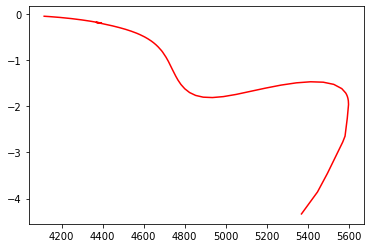

In [208]:
plt.plot(h['Teff'], h['surf_corr'],'r-')

In [199]:
# mode_freq_o
# mode_inertia
# s.loc[idx,:]
width
Dnu_scaling
numax_scaling
# s.loc[idx,'Re(freq)'].to_numpy()
# s.loc[idx,'E_norm'].to_numpy()
s
idx = (s['Re(freq)']> (numax_scaling-3*width)) & (s['Re(freq)'] < (numax_scaling+3*width))
s.loc[idx,:]

,l,n_pg,Re(freq),Im(freq),E_norm
2,0,3,8.339742,0.0,4.155263e-05
3,0,4,10.185257,0.0,1.106157e-05
4,0,5,12.238772,0.0,3.699094e-06
5,0,6,14.229404,0.0,1.934866e-06
6,0,7,16.416327,0.0,9.080678e-07
7,0,8,18.533876,0.0,5.325319e-07
8,0,9,20.753579,0.0,2.976775e-07


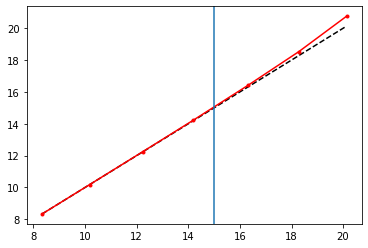

In [200]:
plt.plot(mode_freq, mode_freq, 'k--')
plt.plot(mode_freq, mode_freq_o, 'r.-')
plt.axvline(numax_scaling)

(-0.075, 0.075)

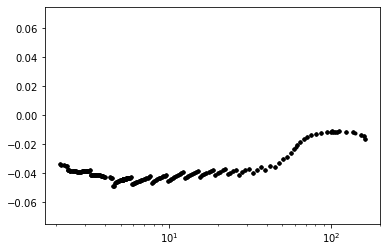

In [189]:
plt.plot(h['Dnu_freq_o'], (h['Dnu_freq']/h['Dnu_freq_o']-1), 'k.')
plt.xscale('log')
plt.ylim(-0.075, 0.075)

In [190]:
h

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o,density,surf_corr,surf_corr2,[M/H]
0,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
1,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
2,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
3,5445.888053,2.0,0.335452,0.047726,0.077374,0.896096,1.0,0.272244,157.245267,159.557733,1.178876,-3.855331,-0.108666,0.460458
4,5445.888053,2.0,0.335452,0.047726,0.077374,0.896096,1.0,0.272244,157.245267,159.557733,1.178876,-3.855331,-0.108666,0.460458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,4121.000168,2.0,0.335452,0.047726,0.077374,15.429598,1.0,12.407329,2.079103,2.152439,0.016499,-0.050582,-0.108666,0.460458
553,4121.000168,2.0,0.335452,0.047726,0.077374,15.429598,1.0,12.407329,2.079103,2.152439,0.016499,-0.050582,-0.108666,0.460458
554,4115.393369,2.0,0.335452,0.047726,0.077374,15.621633,1.0,12.407914,2.041058,2.112739,0.016196,-0.048998,-0.108666,0.460458
555,4115.393369,2.0,0.335452,0.047726,0.077374,15.621633,1.0,12.407914,2.041058,2.112739,0.016196,-0.048998,-0.108666,0.460458


In [191]:
h

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o,density,surf_corr,surf_corr2,[M/H]
0,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
1,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
2,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
3,5445.888053,2.0,0.335452,0.047726,0.077374,0.896096,1.0,0.272244,157.245267,159.557733,1.178876,-3.855331,-0.108666,0.460458
4,5445.888053,2.0,0.335452,0.047726,0.077374,0.896096,1.0,0.272244,157.245267,159.557733,1.178876,-3.855331,-0.108666,0.460458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,4121.000168,2.0,0.335452,0.047726,0.077374,15.429598,1.0,12.407329,2.079103,2.152439,0.016499,-0.050582,-0.108666,0.460458
553,4121.000168,2.0,0.335452,0.047726,0.077374,15.429598,1.0,12.407329,2.079103,2.152439,0.016499,-0.050582,-0.108666,0.460458
554,4115.393369,2.0,0.335452,0.047726,0.077374,15.621633,1.0,12.407914,2.041058,2.112739,0.016196,-0.048998,-0.108666,0.460458
555,4115.393369,2.0,0.335452,0.047726,0.077374,15.621633,1.0,12.407914,2.041058,2.112739,0.016196,-0.048998,-0.108666,0.460458


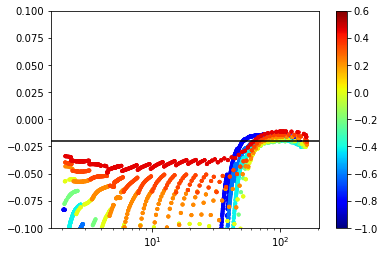

In [192]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=0.6)

idx = track_params['Mass']==1

for itrack, track in track_params.loc[idx,:].iterrows():
    h = pd.read_csv('database/dennisgrid/GRID{:0.0f}.csv'.format(track['GRID']))
    if (np.median(np.log10(h['Zinit']/(1-h['Zinit']-h['Yinit'])) - np.log10(0.0268)) <-1.): continue
    plt.scatter(h['Dnu_freq_o'], (h['Dnu_freq']/h['Dnu_freq_o']-1), marker='.', c=h['[M/H]'], cmap='jet', norm=norm)
plt.xscale('log')
plt.axhline(-0.02, color='k')
plt.ylim(-0.1, 0.1)
plt.colorbar()

In [193]:
h.loc[:80,:]

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o,density,surf_corr,surf_corr2,[M/H]
0,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
1,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
2,5367.893459,2.0,0.335452,0.047726,0.077374,0.890090,1.0,0.074147,158.453530,161.055818,1.190829,-4.331205,-0.108666,0.460458
3,5445.888053,2.0,0.335452,0.047726,0.077374,0.896096,1.0,0.272244,157.245267,159.557733,1.178876,-3.855331,-0.108666,0.460458
4,5445.888053,2.0,0.335452,0.047726,0.077374,0.896096,1.0,0.272244,157.245267,159.557733,1.178876,-3.855331,-0.108666,0.460458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,4823.060629,2.0,0.335452,0.047726,0.077374,2.090736,1.0,11.817810,43.234758,44.837752,0.330789,-1.701396,-0.108666,0.460458
77,4799.800595,2.0,0.335452,0.047726,0.077374,2.180381,1.0,11.853682,40.545714,42.017950,0.310600,-1.620050,-0.108666,0.460458
78,4799.800595,2.0,0.335452,0.047726,0.077374,2.180381,1.0,11.853682,40.545714,42.017950,0.310600,-1.620050,-0.108666,0.460458
79,4799.800595,2.0,0.335452,0.047726,0.077374,2.180381,1.0,11.853682,40.545714,42.017950,0.310600,-1.620050,-0.108666,0.460458


In [59]:
dfreq

array([-2.31348771e-05, -5.57791307e-04, -5.44460781e-03, -1.96845968e-02,
       -6.30355350e-02, -1.97723323e-01, -5.15979360e-01, -1.49767727e+00,
       -5.06611485e+00, -2.02436601e+01])

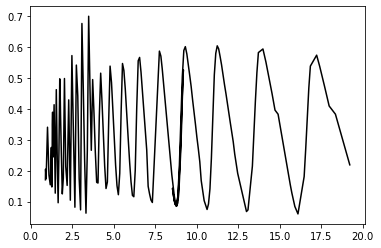

In [45]:
plt.plot(h['radius'], h['Dnu_freq']/h['Dnu_freq_o'], 'k-')

In [39]:
np.log10(0.0268)
h

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o,density
0,5653.211329,2.0,0.278,0.019,-1.568202,0.896264,1.0,0.081550,156.082780,159.525797,1.178544
1,5653.211329,2.0,0.278,0.019,-1.568202,0.896264,1.0,0.081550,156.082780,159.525797,1.178544
2,5653.211329,2.0,0.278,0.019,-1.568202,0.896264,1.0,0.081550,156.082780,159.525797,1.178544
3,5669.588139,2.0,0.278,0.019,-1.568202,0.904686,1.0,0.332087,153.838514,157.340197,1.162126
4,5669.588139,2.0,0.278,0.019,-1.568202,0.904686,1.0,0.332087,153.838514,157.340197,1.162126
...,...,...,...,...,...,...,...,...,...,...,...
469,4218.260315,2.0,0.278,0.019,-1.568202,18.354664,1.0,11.800763,0.641636,1.673728,0.012717
470,4201.568712,2.0,0.278,0.019,-1.568202,19.025983,1.0,11.802146,0.405503,1.589439,0.012050
471,4201.568712,2.0,0.278,0.019,-1.568202,19.025983,1.0,11.802146,0.405503,1.589439,0.012050
472,4196.663326,2.0,0.278,0.019,-1.568202,19.218774,1.0,11.802520,0.343361,1.566297,0.011869


In [ ]:
h['diff_Dnu'] = np.diff(h['delta_nu'], append=0)
h['diff_Dnu2'] = np.diff(np.diff(h['delta_nu'], append=0), prepend=0)

idx = ((h['star_age']/1e9)>0.05) & (h['effective_T']<5500) & (h['diff_Dnu']>0) #& (h['delta_nu']>2)

newh = h.loc[idx,:].reset_index(drop=False)

max_index = newh[newh['diff_Dnu2']<0]['index'].iloc[0]

idx = ((h['star_age']/1e9)>0.05) & (h.index < max_index)  #< (newh[newh < maxlum].sort_values('luminosity', ascending=False).index[0])

# plt.scatter(h.loc[idx,'effective_T'], h.loc[idx,'luminosity'], c=np.diff(h.loc[idx,'luminosity'], append=0), marker='o')
plt.scatter(h.loc[idx,'effective_T'], h.loc[idx,'delta_nu'], marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlim(20000, 4000)
# plt.ylim(0.1, 3000)
plt.ylim(300., 1.0)

# plt.colorbar().set_label('profile number')

# plt.plot(newh['model_number'], newh['luminosity'])
# plt.plot(newh['model_number'], newh['diff_lum2'])
# idx = newh['diff_lum2']<0
# plt.plot(newh.loc[idx,'model_number'], newh.loc[idx,'diff_lum2'], 'r.')


# plt.plot(newh['model_number'], newh['diff_lum'])
# idx = newh['diff_lum']<0
# plt.plot(newh.loc[idx,'model_number'], newh.loc[idx,'diff_lum'], 'r.')

In [29]:
import ebf

In [30]:
data1 = ebf.read('fdnu/grid_interp1.ebf','/data')
data2 = ebf.read('fdnu/grid_interp2.ebf','/data')

[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]


In [31]:
data1

array([(-4.7212464 , 0.8, 1., 3.38  , 0.65774588, 4281.18, 0.94911112, 1.32119412, 0.98787755, 12.83417,  25.66012, 0.99996, 6680),
       (-4.7212464 , 0.8, 1., 3.3881, 0.65774588, 4281.18, 0.94911112, 1.32119412, 0.98787755, 12.83417,  25.66012, 0.99996, 6680),
       (-4.7212464 , 0.8, 1., 3.3962, 0.65774588, 4281.18, 0.94911112, 1.32119412, 0.98787755, 12.83417,  25.66012, 0.99996, 6680),
       ...,
       (-1.32124678, 4. , 2., 4.9838, 2.33292084, 4698.63, 1.02441136, 1.0963788 , 3.63946412,  0.145  , 325.79502, 0.68838, 1930),
       (-1.32124678, 4. , 2., 4.9919, 2.33292084, 4698.63, 1.02441136, 1.0963788 , 3.63946412,  0.145  , 325.79502, 0.68838, 1930),
       (-1.32124678, 4. , 2., 5.    , 2.33292084, 4698.63, 1.02441136, 1.0963788 , 3.63946412,  0.145  , 325.79502, 0.68838, 1930)],
      dtype=[('logz', '<f8'), ('mass', '<f8'), ('evstate', '<f8'), ('logg_teff', '<f8'), ('logg', '<f8'), ('teff', '<f8'), ('fdnu', '<f8'), ('fdnu_int', '<f8'), ('mass_nu', '<f8'), ('age', '<f8')

In [32]:
data2

array([(-4.7212464 ,  0., 1., 3.38  ,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0),
       (-4.7212464 ,  0., 1., 3.3881,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0),
       (-4.7212464 ,  0., 1., 3.3962,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0),
       ...,
       (-1.32124678, 10., 2., 4.9838, 10., 10., 10., 10., 10., 10., 10., 10., 10),
       (-1.32124678, 10., 2., 4.9919, 10., 10., 10., 10., 10., 10., 10., 10., 10),
       (-1.32124678, 10., 2., 5.    , 10., 10., 10., 10., 10., 10., 10., 10., 10)],
      dtype=[('logz', '<f8'), ('mass', '<f8'), ('evstate', '<f8'), ('logg_teff', '<f8'), ('logg', '<f8'), ('teff', '<f8'), ('fdnu', '<f8'), ('fdnu_int', '<f8'), ('mass_nu', '<f8'), ('age', '<f8'), ('dp', '<f8'), ('central_he4', '<f8'), ('model', '<i8')])

In [ ]:
# Read in models

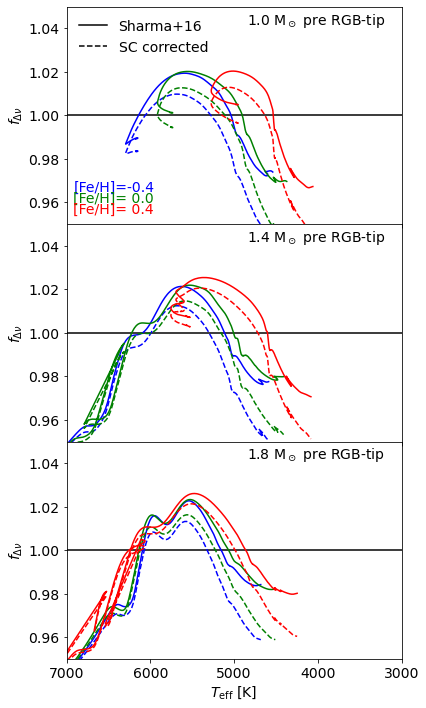

In [21]:
import matplotlib 
matplotlib.rcParams["font.size"] = 14. #7.5

gridspec_kw = {'hspace':0., 'wspace':0.2}
fig, axes = plt.subplots(figsize=[6,12], nrows=3, ncols=1, squeeze=False, sharex=True, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

masses = np.array([1.0, 1.4, 1.8]) #np.arange(0.7, 0.71, 0.1)
fehs = np.array([-0.4, 0.0, 0.4])

version = 'v2'
model = 'cubic_linear'
# model = 'combined_linear'

colors = ['blue', 'green', 'red']

gamlt = 1.9
for imass, gmass in enumerate(masses):
    for ifeh, gfeh in enumerate(fehs):
        idx = (newgrid['mass']==gmass) & (newgrid['feh']==gfeh) & (newgrid['amlt']==gamlt)

        index = newgrid[idx][0]['index']
        filepath = rootpath+'hpc/coarse_{:s}/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(version, index)
        if not os.path.exists(filepath): continue
        f = h5py.File(filepath, 'r')

        idx = (f['flag_seismo'][:]==1) & (f['phase'][:]>=0)
        Nmodel = np.sum(idx)
        model_number = f['model_number'][idx]
        profile_number = f['profile_number'][idx]
        Teff = f['Teff'][idx]
        grav = f['star_mass'][idx]/f['radius'][idx]**2.0
        numax = f['numax_scaling'][idx]
        Dnu = f['delta_nu_scaling'][idx]
        mass = f['star_mass'][idx]
        radius = f['radius'][idx]
        feh = f['FeH'][idx]
        fdnu, fdnu_corr1, fdnu_corr2 = [np.zeros(Nmodel) for i in range(3)]
        for imod in range(Nmodel):
            density = mass[imod]/radius[imod]**3.0
            mode_freq = f['profile{:0.0f}/freq'.format(profile_number[imod])][:][0]
            mode_inertia = f['profile{:0.0f}/E_norm'.format(profile_number[imod])][:][0]
            mode_l = f['profile{:0.0f}/l'.format(profile_number[imod])][:][0]
            Dnu_mod = se.get_model_Dnu(mode_freq, mode_l, None, numax[imod])
            fdnu[imod] = (Dnu_mod/135.1)*(density)**-0.5 #135.1

            # model=="cubic_linear":
            thetas = np.array([-4.3072, 0.9684, -5.9636, -1.0273])
            D1 = thetas[0] * (grav[imod])**thetas[1] * (Teff[imod]/5777.)**thetas[2] * (thetas[3]*feh[imod] + 1) # surf corr at numax

            fi = scipy.interpolate.interp1d(mode_freq, (mode_freq/numax[imod])**3.0/mode_inertia, kind='cubic')
            gs = fi(numax[imod])

            surface_a3 = D1/gs
            dfreq1 = (surface_a3*(mode_freq/numax[imod])**3.0)/mode_inertia

            mode_freq_corr = mode_freq + dfreq1
            Dnu_mod_corr = se.get_model_Dnu(mode_freq_corr, mode_l, None, numax[imod])
            fdnu_corr1[imod] = (Dnu_mod_corr/135.1)*(density)**-0.5

        axes[imass].plot(Teff, fdnu, linestyle='-', color=colors[ifeh])
        axes[imass].plot(Teff, fdnu_corr1, linestyle='--', color=colors[ifeh])
    axes[imass].axis([7000, 3000, 0.95, 1.05])
    axes[imass].plot([0., 1e7], [1, 1], linestyle='-', color='k', zorder=-1)

    axes[imass].text(0.95, 0.92, '{:0.1f} M$_\\odot$ pre RGB-tip'.format(gmass, gamlt), transform=axes[imass].transAxes, ha='right')

axes[0].text(0.02, 0.15, '[Fe/H]=-0.4', color='blue', transform=axes[0].transAxes, )
axes[0].text(0.02, 0.10, '[Fe/H]= 0.0', color='green',transform=axes[0].transAxes)
axes[0].text(0.02, 0.05, '[Fe/H]= 0.4', color='red',transform=axes[0].transAxes)

for i in range(3):
    axes[i].set_ylabel('$f_{\\Delta\\nu}$')

axes[2].set_xlabel('$T_{\\rm eff}$ [K]')

axes[0].plot([0,1],[0,0],'k-',label='Sharma+16')
axes[0].plot([0,1],[0,0],'k--',label='SC corrected')
axes[0].legend(loc=2,edgecolor='none')

# plt.savefig(work_dir+'fdnu.pdf')
# plt.savefig(work_dir+'fdnu_vs_Teff.png')

In [14]:
newgrid

array([(1. , -0.4, 1.6, 1576, 0.3725397 , 1.01286, -0.44230798, 1.557928),
       (1. ,  0. , 1.6, 1495, 0.41498938, 0.98893, -0.05744488, 1.626971),
       (1. ,  0.4, 1.6,  823, 0.32975316, 1.0485 ,  0.38415664, 1.573651),
       (1.4, -0.4, 1.6,  174, 0.20374179, 1.38432, -0.37343583, 1.632953),
       (1.4,  0. , 1.6,  601, 0.21476546, 1.43327, -0.02873397, 1.614667),
       (1.4,  0.4, 1.6, 1281, 0.27307695, 1.35222,  0.41833636, 1.610565),
       (1.8, -0.4, 1.6,  426, 0.37307715, 1.75346, -0.43085834, 1.62475 ),
       (1.8,  0. , 1.6, 1365, 0.31166422, 1.75065,  0.01364884, 1.577753),
       (1.8,  0.4, 1.6,   53, 0.24351501, 1.79448,  0.43047014, 1.638422),
       (1. , -0.4, 1.9,  456, 0.16440089, 1.01909, -0.40898278, 1.865375),
       (1. ,  0. , 1.9, 1543, 0.10799351, 0.9738 ,  0.00612937, 1.918866),
       (1. ,  0.4, 1.9, 2039, 0.1316249 , 1.02165,  0.42038712, 1.879218),
       (1.4, -0.4, 1.9, 1870, 0.19554076, 1.40934, -0.37941748, 1.938007),
       (1.4,  0. , 1.9, 1

# what is the model uncertainty on fDnu due to Yinit and amlt

In [12]:
data = pd.read_parquet('models/fDnu/fDnu_grid.parquet')
data

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o
0,5473.038775,1.539984,0.281014,0.004940,0.006918,0.721764,0.77866,0.043321,191.853138,194.258324
1,5466.737496,1.539984,0.281014,0.004940,0.006918,0.720247,0.77866,0.044788,192.444121,194.877970
2,5462.520256,1.539984,0.281014,0.004940,0.006918,0.719735,0.77866,0.046548,192.643821,195.094229
3,5460.155294,1.539984,0.281014,0.004940,0.006918,0.719967,0.77866,0.048659,192.550859,195.007745
4,5457.494477,1.539984,0.281014,0.004940,0.006918,0.721361,0.77866,0.054234,191.999750,194.457692
...,...,...,...,...,...,...,...,...,...,...
6587248,3842.598494,1.473590,0.309145,0.028782,0.044494,13.031104,0.75376,38.000437,2.338914,2.425903
6587249,3837.147782,1.473590,0.309145,0.028782,0.044494,13.216241,0.75376,38.001707,2.290099,2.376194
6587250,3831.716272,1.473590,0.309145,0.028782,0.044494,13.401635,0.75376,38.002941,2.243241,2.328393
6587251,3826.471624,1.473590,0.309145,0.028782,0.044494,13.587498,0.75376,38.004139,2.198178,2.282296


In [13]:
masses = [1.0, 1.4, 1.8]
fehs = [-0.4, 0., 0.4] #[-0.4, 0., 0.4]

columns=['mass', 'feh', 'radius', 'Teff', 'lum', 'grav', 'numax']
numax_points = [3090, 2000, 1000, 500, 200, 100] # numaxes muHz

fakestars = []
for imass in range(len(masses)):
    for ifeh in range(len(fehs)):
        # read in MIST models
        g = se.MIST_EEP('mist/m{:0.0f}feh{:03.0f}.track.eep'.format(masses[imass]*10, fehs[ifeh]*10))
        
        idx = (g.eeps['phase']>=0) & (g.eeps['phase']<=2) & (g.eeps['delta_nu']>2)
        Nstar = np.sum(idx)
        
        mass = np.zeros(Nstar) + masses[imass] #g.eeps['star_mass'][idx] # np.zeros(Nstar)+masses[imass]
        feh = np.zeros(Nstar) + fehs[ifeh] #
        radius = 10.0**g.eeps['log_R'][idx]
        Teff = 10.0**g.eeps['log_Teff'][idx]
        lum = 10.0**g.eeps['log_L'][idx]
        grav = mass * radius**-2.0
        numax = grav * (Teff/5777)**-0.5 * 3090
        
        for numax_point in numax_points:
            idx = np.argmin(np.abs(numax-numax_point))
            fakestars.append((mass[idx], feh[idx], radius[idx], Teff[idx], lum[idx], grav[idx], numax[idx]))
        
fakestars = pd.DataFrame(fakestars, columns=columns)
fakestars['e_Teff'] = fakestars['Teff']*0.024
fakestars['e_lum'] = fakestars['lum']*0.02
fakestars['e_feh'] = 0.1
fakestars['e_numax'] = fakestars['numax']*0.02

Reading in: mist/m10feh-04.track.eep
Reading in: mist/m10feh000.track.eep
Reading in: mist/m10feh004.track.eep
Reading in: mist/m14feh-04.track.eep
Reading in: mist/m14feh000.track.eep
Reading in: mist/m14feh004.track.eep
Reading in: mist/m18feh-04.track.eep
Reading in: mist/m18feh000.track.eep
Reading in: mist/m18feh004.track.eep


In [ ]:
fakestars

In [15]:
from fdnu.asfgrid import Seism
import scaling
# amlt = 1.7, 2.3, sig=0.1
# Yinit = 0.25, 0.29, sig=0.01
params_combs = [[None, 1.7],
                [None, 2.3],
                [0.25, None],
                [0.29, None]]

for mean_Yinit, mean_amlt in params_combs:
    print('mean_Yinit, mean_amlt: ', mean_Yinit, ',', mean_amlt)
    s = scaling.seismo(path_grid_models='models/fDnu/fDnu_grid.parquet',
                       mean_Yinit=mean_Yinit, sig_Yinit=0.01,
                       mean_amlt=mean_amlt, sig_amlt=0.1)
    s.set_observables(
                      MH=fakestars['feh'].to_numpy(), 
                      e_MH=fakestars['e_feh'].to_numpy(), 
                      numax=fakestars['numax'].to_numpy(), 
                      e_numax=fakestars['e_numax'].to_numpy(), 
                      Teff=fakestars['Teff'].to_numpy(), 
                      e_Teff=fakestars['e_Teff'].to_numpy(),
                      lum=fakestars['lum'].to_numpy(),
                      e_lum=fakestars['e_lum'].to_numpy()
    )
    fDnu, e_fDnu = s._get_estimators('fDnu')
    fakestars['fDnu_{:.2f}'.format(mean_Yinit or mean_amlt)] = fDnu
    fakestars['e_fDnu_{:.2f}'.format(mean_Yinit or mean_amlt)] = e_fDnu

mean_Yinit, mean_amlt:  None , 1.7
mean_Yinit, mean_amlt:  None , 2.3
mean_Yinit, mean_amlt:  0.25 , None
mean_Yinit, mean_amlt:  0.29 , None


In [67]:
# import importlib
# importlib.reload(scaling)

<module 'scaling' from '/import/silo3/yali4742/numax-sc-metallicity/surface/scaling.py'>

In [18]:
# print('Uniform priors')
# s = scaling.seismo(path_grid_models='models/fDnu/fDnu_grid.parquet')
# s.set_observables(
#                   MH=fakestars['feh'].to_numpy(), 
#                   e_MH=fakestars['e_feh'].to_numpy(), 
#                   numax=fakestars['numax'].to_numpy(), 
#                   e_numax=fakestars['e_numax'].to_numpy(), 
#                   Teff=fakestars['Teff'].to_numpy(), 
#                   e_Teff=fakestars['e_Teff'].to_numpy(),
#                   lum=fakestars['lum'].to_numpy(),
#                   e_lum=fakestars['e_lum'].to_numpy()
# )
# fDnu, e_fDnu = s._get_estimators('fDnu_t')
# fakestars['fDnu_t'.format(mean_Yinit or mean_amlt)] = fDnu
# fakestars['e_fDnu_t'.format(mean_Yinit or mean_amlt)] = e_fDnu

In [19]:
fDnu, e_fDnu = s._get_estimators('fDnu')
fakestars['fDnu'.format(mean_Yinit or mean_amlt)] = fDnu
fakestars['e_fDnu'.format(mean_Yinit or mean_amlt)] = e_fDnu

In [20]:
fakestars.to_csv('data/fDnu_model_physics_data.csv')

KeyError: 'fDnu_t'

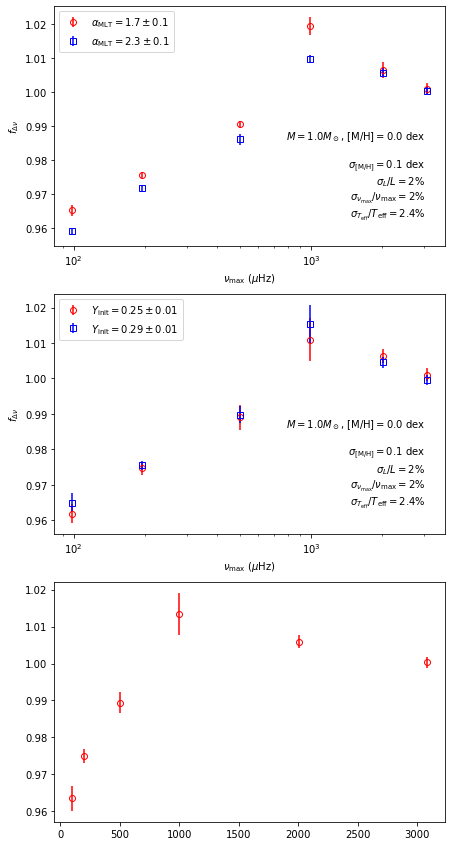

In [23]:
# fig, axes = plt.subplots(figsize=[18,5], nrows=1, ncols=3, squeeze=False)
fig, axes = plt.subplots(figsize=[7,15], nrows=3, ncols=1, squeeze=False)
axes = axes.reshape(-1)

# params = [[mass, feh] for mass in [1.0] for feh in [-0.4, 0., 0.4]]
# params = [[mass, feh] for mass in [1.0] for feh in [0]]
# mass, feh = params[iax][0], params[iax][1]
mass, feh = 1.0, 0.
idx = (fakestars['mass']==mass) & (fakestars['feh']==feh)
    
params = [{'yval':['fDnu_1.70', 'fDnu_2.30'],
           'label':[r'$\alpha_{\rm MLT}=1.7\pm0.1$', r'$\alpha_{\rm MLT}=2.3\pm0.1$']},
          {'yval':['fDnu_0.25', 'fDnu_0.29'],
           'label':[r'$Y_{\rm init}=0.25\pm0.01$', r'$Y_{\rm init}=0.29\pm0.01$']},
          {'yval':['fDnu', 'fDnu_t'],
           'label':['5w range', '3Dnu range']}]
          
for iax, ax in enumerate(axes):
    param = params[iax]
    ax.errorbar(
        fakestars.loc[idx,'numax'], 
        fakestars.loc[idx,param['yval'][0]],
        yerr=fakestars.loc[idx,'e_'+param['yval'][0]],
        mec='r', ecolor='r', marker='o', 
        mfc='none', linestyle='none', 
        label=param['label'][0]
    )

    ax.errorbar(
        fakestars.loc[idx,'numax'], 
        fakestars.loc[idx,param['yval'][1]],
        yerr=fakestars.loc[idx,'e_'+param['yval'][1]],
        mec='b', ecolor='b', marker='s', 
        mfc='none', linestyle='none',
        label=param['label'][1]
    )

    ax.legend()
    ax.set_xlabel(r'$\nu_{\rm max}$ ($\mu$Hz)')
    ax.set_ylabel(r'$f_{\Delta\nu}$')
    ax.set_xscale('log')
    ax.text(
        0.95, 0.05,
        '$M={:0.1f}$'.format(mass)+r'$M_\odot$, ${\rm [M/H]} ='+'{:0.1f}$ dex'.format(feh)+'\n\n'+
        r'$\sigma_{\rm [M/H]}=0.1$ dex'+'\n'+
        r'$\sigma_L/L=2\%$'+'\n'+
        r'$\sigma_{\nu_{\rm max}}/{\nu_{\rm max}}=2\%$'+'\n'+
        r'$\sigma_{T_{\rm eff}}/{T_{\rm eff}}=2.4\%$'+'\n',
        ha='right', va='bottom', transform=ax.transAxes
    )

# plt.savefig('fdnu_model_physics.jpg',dpi=150)

## For Claudia M67

In [121]:
m67 = pd.read_csv('claudia_m67_pysyd_apogee_gaiadr2.csv')
m67

d = pd.read_csv('isoclassify_smaller.csv')
d['EPIC'] = d['id_starname'].apply(lambda x:int(x[5:]) )
d['lum'] = d['dir_lum']
d['e_lum'] = (np.abs(d['dir_lum_err1']) + np.abs(d['dir_lum_err2']))/2.

m67 = m67.merge(d[['EPIC', 'lum', 'e_lum']], on='EPIC', how='left')

In [122]:
m67.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPIC                45 non-null     int64  
 1   numax_gauss         45 non-null     float64
 2   numax_gauss_uncert  45 non-null     float64
 3   dnu                 45 non-null     float64
 4   dnu_uncert          45 non-null     float64
 5   teff_irfm           45 non-null     float64
 6   e_teff_irfm         45 non-null     float64
 7   2MASS               45 non-null     object 
 8   J                   45 non-null     float64
 9   J_ERR               44 non-null     float64
 10  H                   45 non-null     float64
 11  H_ERR               44 non-null     float64
 12  K                   45 non-null     float64
 13  K_ERR               45 non-null     float64
 14  LOGG                45 non-null     float64
 15  LOGG_ERR            45 non-null     float64
 16  M_H       

In [136]:
m67.loc[:,'fdnu'] = np.nan
m67.loc[:,'e_fdnu'] = np.nan

In [137]:
import scaling

idx = (m67['lum']/m67['e_lum']>4) & (m67['dnu']>=2)
s = scaling.seismo(path_grid_models='models/fDnu/fDnu_grid.parquet')
s.set_observables(
                  MH=m67.loc[idx,'M_H'].to_numpy(), 
                  e_MH=np.zeros(len(m67.loc[idx,'M_H']))+0.1, 
                  numax=m67.loc[idx,'numax_gauss'].to_numpy(), 
                  e_numax=m67.loc[idx,'numax_gauss_uncert'].to_numpy(), 
                  Dnu=m67.loc[idx,'dnu'].to_numpy(),
                  e_Dnu=m67.loc[idx,'dnu_uncert'].to_numpy(),
                  Teff=m67.loc[idx,'teff_irfm'].to_numpy(), 
                  e_Teff=m67.loc[idx,'e_teff_irfm'].to_numpy(),
                  lum=m67.loc[idx,'lum'].to_numpy(), 
                  e_lum=m67.loc[idx,'e_lum'].to_numpy(),
)
m67.loc[idx,'fdnu'], m67.loc[idx,'e_fdnu'] = s._get_estimators('fDnu')

Text(0, 0.5, 'fDnu')

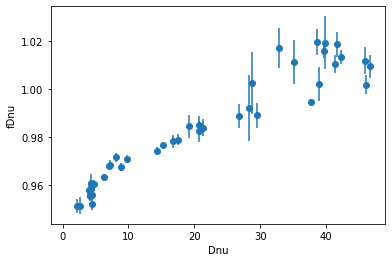

In [145]:
plt.errorbar(m67['dnu'], m67['fdnu'], yerr=m67['e_fdnu'], linestyle='none', marker='o')
plt.xlabel('Dnu')
plt.ylabel('fDnu')

In [146]:
m67.to_csv('pysyd_apogee_gaiadr2_fdnu.csv', index=False)

# excursion at R~15: is it due to AGB contamination?
Galaxia

In [19]:
gal = np.load('../../../nike/sample/kepler_galaxia_mist_uncofeh.npy')

(4.0, 20.0)

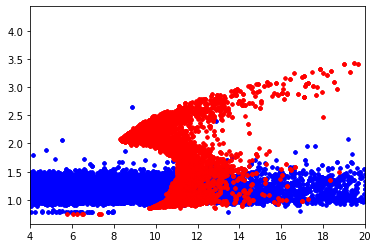

In [24]:
rgb = gal['phase']==2
heb = gal['phase']==3
plt.plot(gal['radius'][rgb], gal['mass'][rgb], 'b.')

plt.plot(gal['radius'][heb], gal['mass'][heb], 'r.')

plt.xlim(4,20)

# plt.

(1.0, 40.0)

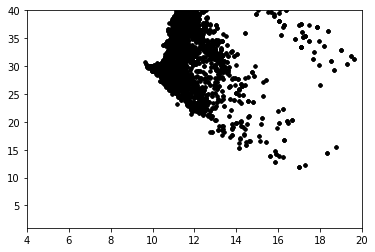

In [28]:
plt.plot(gal['radius'][heb], gal['nu_max'][heb], 'k.')
plt.xlim(4,20)
plt.ylim(1,40)

In [53]:
df = pd.read_csv('../../../database/catalog/dreau+2021-agb.csv')
yu = pd.read_csv('../../../database/catalog/yu+2018.csv')
df = df.merge(yu[['KIC', 'NoCorR', 'Phase']], on='KIC', how='left')


In [54]:
df

,KIC,Dnu,M,Teff,eps,e_eps,d01,e_d01,d02,e_d02,...,e_A1,A2,e_A2,eta,evo,Simbad,_RA,_DE,NoCorR,Phase
0,1026309,1.944,2.58,4514,0.795,0.011,-0.043,0.017,0.126,0.007,...,34.4,136.9,30.5,0.65,,Simbad,291.10986,36.73318,23.71,0.0
1,1160789,3.524,0.86,4724,0.95,0.014,-0.053,0.021,0.144,0.011,...,73.6,105,19.4,0.379,1,Simbad,290.88666,36.87243,10.72,2.0
2,1162746,3.804,0.85,4762,0.956,0.016,-0.093,0.023,0.173,0.012,...,,83.8,13.5,0.28,1,Simbad,291.35999,36.81989,10.96,2.0
3,1163359,2.644,1.67,4560,0.855,0.012,-0.013,0.017,0.143,0.008,...,25.8,117.9,27,0.932,0,Simbad,291.49326,36.84881,16.11,1.0
4,1432587,1.082,0.85,4295,0.635,0.011,-0.042,0.017,0.171,0.009,...,113.5,362.9,133.5,1.253,0,Simbad,291.45773,37.01747,24.32,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,10878816,3.070,2.43,4872,0.881,0.014,-0.034,0.019,0.131,0.01,...,18.6,57,10.1,,1,Simbad,298.13901,48.29175,16.89,2.0
2099,11076239,0.714,0.92,3989,0.519,0.011,-0.091,0.017,0.165,0.01,...,180.1,414.5,183.2,,3,Simbad,287.61929,48.63290,NaN,NaN
2100,11305937,1.349,1.20,4267,0.718,0.01,-0.027,0.018,0.14,0.009,...,75.2,290.7,91.9,,3,Simbad,295.93964,49.01591,NaN,NaN
2101,11619724,2.482,2.57,4761,0.84,0.013,-0.017,0.02,0.138,0.01,...,53,73.6,18.6,,3,Simbad,296.00409,49.66842,20.63,0.0


Text(0, 0.5, 'Count')

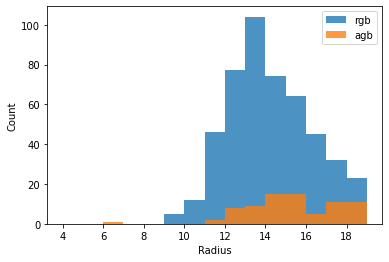

In [62]:
bins = np.arange(4,20,1)
rgb = df['evo']=='0'
# rgb = df['Phase']==1
plt.hist(df.loc[heb,'NoCorR'], label='rgb', bins=bins, alpha=0.8)

# rc = (df['evo']=='1') | (df['evo']=='2')
# rc = df['Phase']==2
# plt.hist(df.loc[rc,'NoCorR'], label='rc', bins=bins, alpha=0.8)

agb = (df['evo']=='3')
plt.hist(df.loc[agb,'NoCorR'], label='agb', bins=bins, alpha=0.8)

plt.legend()

plt.xlabel('Radius')
plt.ylabel('Count')